## Configufittion

In [1]:
import sys
import os 

model_name = 'pad-test-model.pkl'
SEED = 42
VAL_PCT = 0.2
INFER = True
DEBUG = True

GRADIENT = os.path.exists('train')
KAGGLE = os.path.exists('../input')

if KAGGLE:
    sys.path.insert(0, '../input/uwmadisonutils/')
    data_path = '../input/uw-madison-gi-tract-image-segmentation/'
    model_name = '../input/uw-madison-models/' + model_name
    
elif GRADIENT:
    sys.path.insert(0, 'uwmadisonutils/')
    data_path = ''
    model_name = 'kaggle-models/' + model_name 

from uwmadisonutils.utilities import *

## Libraries and Data

In [2]:
if KAGGLE:
    !cp -r ../input/pytorch-segmentation-models-lib/ ./
    !pip install -q ./pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
    !pip install -q ./pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
    !pip install -q ./pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
    !pip install -q ./pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

## Prepare Data

In [3]:
path = Path(data_path+'train')
test_path = Path(data_path+'test')

train = pd.read_csv(data_path+'train.csv', low_memory=False)
sample_submission = pd.read_csv(data_path+'sample_submission.csv', low_memory=False).rename(columns={'predicted': 'segmentation'})

train_path = Path(data_path+'train')
test_path = Path(data_path+'test')

train_fnames = get_image_files(train_path)
test_fnames = get_image_files(test_path)

In [4]:
# if sample_submission.shape[0] > 0: 
#     test = sample_submission.copy()
# else:
#     test_fnames = train_fnames
#     test_path = train_path
#     test = train.copy()
#     test = test.sample(frac=1.0, random_state=SEED)

# test = get_custom_df(test, test_fnames, str(test_path), channels=5, stride=1)
# train = get_custom_df(train, train_fnames, str(train_path), channels=5, stride=1)

# Model Training

In [5]:
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    order = TrackerCallback.order+1
    def __init__(self,
        monitor='valid_loss', # value (usually loss or metric) being monitored.
        comp=None, # numpy comparison operator; np.less if monitor is loss, np.greater if monitor is metric.
        min_delta=0., # minimum delta between the last monitor value and the best monitor value.
        fname='model', # model name to be used when saving model.
        every_epoch=False, # if true, save model after every epoch; else save only when model is better than existing best.
        at_end=False, # if true, save model when training ends; else load best model if there is only one saved model.
        with_opt=False, # if true, save optimizer state (if any available) when saving model.
        reset_on_fit=True, # before model fitting, reset value being monitored to -infinity (if monitor is metric) or +infinity (if monitor is loss).,
        save_at_epoch=None,
        resume_from=0
    ):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt,save_at_epoch,resume_from')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.epoch >= self.resume_from:
            if self.save_at_epoch == self.epoch:
                print(f'Saved final mini-run at epoch {self.epoch}')
                self._save(f'{self.fname}_final')
            
            elif self.every_epoch:
                if (self.epoch%self.every_epoch) == 0: self._save(f'{self.fname}_{self.epoch}')
                
            else: #every improvement
                super().after_epoch()
                if self.new_best:
                    print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
                    self._save(f'{self.fname}')
            

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)
        
        


## exp-36

In [6]:
run = 'exp-36'

In [7]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [8]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout()
            ])

def get_test_aug(img_size, resize=0.5, crop=0.9):
    crop_size = [round(crop*size) for size in img_size]
    resize = [round(resize*size) for size in crop_size]
    
    if crop < 1.0:
        crop_size = [crop_size[0], crop_size[0]]
        resize = [resize[0], resize[0]]
    
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
        albumentations.Resize(height=resize[0], width=resize[1], always_apply=True)
    ])

In [9]:
def deep_supervision_loss(inp, targ, loss_func=ComboLoss()):
    loss = 0
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

### fold 0

In [10]:
tfms_kwargs = dict(train=get_train_aug, test=get_test_aug)

In [11]:
fold = 0

In [12]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=32, crop=0.6, val_crop=0.6, resize=1.0, aug='albumentations',
                          sample_empty=True, empty_frac=0.5, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [13]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('resnest200e', channels, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=[GradientAccumulation(64), MixUp()],
                          )

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest200-75117900.pth" to /root/.cache/torch/hub/checkpoints/resnest200-75117900.pth


In [14]:
learn.unfreeze()

SuggestedLRs(valley=0.0006918309954926372, steep=0.010964781977236271, slide=0.0063095735386013985)

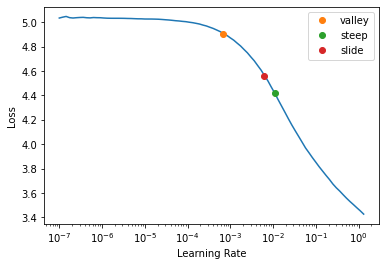

In [15]:
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [16]:
import wandb

from fastai.callback.wandb import WandbCallback

In [15]:
save_at_epoch = 32

In [18]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
learn.fit_one_cycle(100, 2e-2, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}', with_opt=True, save_at_epoch=save_at_epoch),
                                    WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.08553574549335768.
Better model found at epoch 1 with dice_coeff_deep value: 0.5833726889972333.
Better model found at epoch 3 with dice_coeff_deep value: 0.6237209578504874.
Better model found at epoch 7 with dice_coeff_deep value: 0.6414036100188776.
Better model found at epoch 10 with dice_coeff_deep value: 0.6489911505582613.
Better model found at epoch 17 with dice_coeff_deep value: 0.6660917915695276.


RuntimeError: Caught RuntimeError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/opt/conda/lib/python3.8/site-packages/fastai/data/load.py", line 143, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/opt/conda/lib/python3.8/site-packages/fastai/data/load.py", line 173, in do_batch
    def do_batch(self, b): return self.retain(self.create_batch(self.before_batch(b)), b)
  File "/opt/conda/lib/python3.8/site-packages/fastai/data/load.py", line 169, in create_batch
    try: return (fa_collate,fa_convert)[self.prebatched](b)
  File "/opt/conda/lib/python3.8/site-packages/fastai/data/load.py", line 55, in fa_collate
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
  File "/opt/conda/lib/python3.8/site-packages/fastai/data/load.py", line 55, in <listcomp>
    else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
  File "/opt/conda/lib/python3.8/site-packages/fastai/data/load.py", line 54, in fa_collate
    return (default_collate(t) if isinstance(b, _collate_types)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 136, in default_collate
    storage = elem.storage()._new_shared(numel)
  File "/opt/conda/lib/python3.8/site-packages/torch/storage.py", line 486, in _new_shared
    untyped_storage = module.UntypedStorage._new_shared(size * cls().element_size())
  File "/opt/conda/lib/python3.8/site-packages/torch/storage.py", line 173, in _new_shared
    return cls._new_using_fd(size)
RuntimeError: unable to open shared memory object </torch_7145_1> in read-write mode: File exists (17)


In [16]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [17]:
import wandb

from fastai.callback.wandb import WandbCallback

In [17]:
save_at_epoch = 17+38
resume_from = 18

In [19]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 18 with dice_coeff_deep value: 0.6920345384374835.
Better model found at epoch 19 with dice_coeff_deep value: 0.6957557121192063.
Better model found at epoch 20 with dice_coeff_deep value: 0.6984854528278748.
Better model found at epoch 21 with dice_coeff_deep value: 0.7083734905698081.
Better model found at epoch 25 with dice_coeff_deep value: 0.7188627116006724.


In [18]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [21]:
import wandb

from fastai.callback.wandb import WandbCallback

In [22]:
save_at_epoch = 99
resume_from = 56

In [23]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 56 with dice_coeff_deep value: 0.7240935268884272.
Better model found at epoch 57 with dice_coeff_deep value: 0.7268831903774465.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (ConnectionError), entering retry loop.
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)
learn.dls = dls
learn.validate()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(#3) [0.4480319619178772,0.7584678997488117,0.856853234992367]

## exp-34

In [6]:
run = 'exp-34'

In [7]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [8]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout()
            ])

def get_test_aug(img_size, resize=0.5, crop=0.9):
    crop_size = [round(crop*size) for size in img_size]
    resize = [round(resize*size) for size in crop_size]
    
    if crop < 1.0:
        crop_size = [crop_size[0], crop_size[0]]
        resize = [resize[0], resize[0]]
    
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
        albumentations.Resize(height=resize[0], width=resize[1], always_apply=True)
    ])

In [9]:
def deep_supervision_loss(inp, targ, loss_func=ComboLoss()):
    loss = 0
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

### fold 0

In [10]:
tfms_kwargs = dict(train=get_train_aug, test=get_test_aug)

In [11]:
fold = 0

In [12]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [13]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('regnety_160', channels, 3, pretrained=True),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=[GradientAccumulation(64), MixUp()],
                           wd=1e-3
                          )

Downloading: "https://dl.fbaipublicfiles.com/deit/regnety_160-a5fe301d.pth" to /root/.cache/torch/hub/checkpoints/regnety_160-a5fe301d.pth


In [14]:
learn.unfreeze()

SuggestedLRs(valley=0.0020892962347716093, steep=0.004365158267319202, slide=0.2089296132326126)

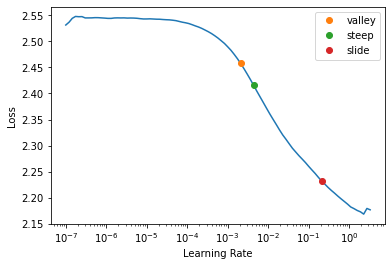

In [15]:
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [16]:
import wandb

from fastai.callback.wandb import WandbCallback

In [21]:
save_at_epoch = 43

In [18]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}', with_opt=True, save_at_epoch=save_at_epoch),
                                    WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.38038007746270613.
Better model found at epoch 1 with dice_coeff_deep value: 0.5815824165352892.
Better model found at epoch 3 with dice_coeff_deep value: 0.5987882355104773.
Better model found at epoch 4 with dice_coeff_deep value: 0.6016903393725741.
Better model found at epoch 8 with dice_coeff_deep value: 0.6393577199162573.
Better model found at epoch 11 with dice_coeff_deep value: 0.6604314493974026.


In [22]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [23]:
import wandb

from fastai.callback.wandb import WandbCallback

In [15]:
save_at_epoch = 56
resume_from = 12

In [25]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 12 with dice_coeff_deep value: 0.5182551831955071.
Better model found at epoch 13 with dice_coeff_deep value: 0.5701929602280201.
Better model found at epoch 14 with dice_coeff_deep value: 0.6351081005578798.
Better model found at epoch 16 with dice_coeff_deep value: 0.6548226001406394.
Better model found at epoch 18 with dice_coeff_deep value: 0.6636662707852189.
Better model found at epoch 21 with dice_coeff_deep value: 0.6831189670466411.
Better model found at epoch 24 with dice_coeff_deep value: 0.6898526330777157.
Better model found at epoch 27 with dice_coeff_deep value: 0.7075727461234628.
Better model found at epoch 43 with dice_coeff_deep value: 0.7105006661474446.
Better model found at epoch 44 with dice_coeff_deep value: 0.7178326692118624.
Better model found at epoch 53 with dice_coeff_deep value: 0.7181071887428797.


In [16]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [19]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)
learn.dls = dls
learn.validate()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(#3) [0.4480319619178772,0.7584678997488117,0.856853234992367]

#### REMINDER: CONTINUE TRAINING

In [17]:
import wandb

from fastai.callback.wandb import WandbCallback

In [15]:
save_at_epoch = 99
resume_from = 58

In [19]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 58 with dice_coeff_deep value: 0.7247909263512109.
Better model found at epoch 59 with dice_coeff_deep value: 0.7257103139351898.
Better model found at epoch 60 with dice_coeff_deep value: 0.7259944542160401.
Better model found at epoch 61 with dice_coeff_deep value: 0.7293797642507635.
Better model found at epoch 66 with dice_coeff_deep value: 0.7299103191187998.
Better model found at epoch 70 with dice_coeff_deep value: 0.730960950395594.
Better model found at epoch 72 with dice_coeff_deep value: 0.7339433702007976.
Better model found at epoch 78 with dice_coeff_deep value: 0.7353791866465625.


In [16]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [17]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=48, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [18]:
learn.dls = dls

In [19]:
learn.validate()

(#3) [0.4468100965023041,0.7367340492830239,0.8418893057147911]

In [20]:
learn.export(f'uwmadisonutils/{run}-f{fold}-e{save_at_epoch}.pkl')

### fold 1

In [12]:
tfms_kwargs = dict(train=get_train_aug, test=get_test_aug)

In [13]:
fold = 1

In [14]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [15]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('regnety_160', channels, 3, pretrained=True),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=[GradientAccumulation(64), MixUp()],
                           wd=1e-3
                          )

In [16]:
learn.unfreeze()

SuggestedLRs(valley=0.0012022644514217973, steep=0.005248074419796467, slide=0.12022644281387329)

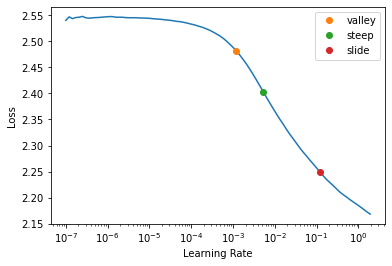

In [15]:
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [18]:
import wandb

from fastai.callback.wandb import WandbCallback

In [20]:
save_at_epoch = 44

In [20]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}', with_opt=True, save_at_epoch=save_at_epoch),
                                    WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.3789102331974043.
Better model found at epoch 1 with dice_coeff_deep value: 0.6170945368091311.
Better model found at epoch 2 with dice_coeff_deep value: 0.6274490389043923.
Better model found at epoch 7 with dice_coeff_deep value: 0.6383414374975122.
Better model found at epoch 11 with dice_coeff_deep value: 0.6556729584415043.
Better model found at epoch 14 with dice_coeff_deep value: 0.6587197835956845.
Better model found at epoch 15 with dice_coeff_deep value: 0.6611687788373234.
Better model found at epoch 19 with dice_coeff_deep value: 0.6965244825828169.
Better model found at epoch 24 with dice_coeff_deep value: 0.697365695397518.
Better model found at epoch 26 with dice_coeff_deep value: 0.7095543999068511.
Better model found at epoch 29 with dice_coeff_deep value: 0.7168658961868611.
Better model found at epoch 31 with dice_coeff_deep value: 0.7256997263519575.
Better model found at epoch 33 with dice_coeff_deep value

In [21]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [22]:
import wandb

from fastai.callback.wandb import WandbCallback

In [17]:
save_at_epoch = 75
resume_from = 34

In [24]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 34 with dice_coeff_deep value: 0.7210456097557671.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Saved final mini-run at epoch 75


In [18]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [19]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)
learn.dls = dls
learn.validate()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(#3) [0.4480319619178772,0.7584678997488117,0.856853234992367]

#### REMINDER: CONTINUE TRAINING

In [16]:
import wandb

from fastai.callback.wandb import WandbCallback

In [14]:
save_at_epoch = 99
resume_from = 76

In [18]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 62 with dice_coeff_deep value: 0.6941670901766381.
Better model found at epoch 63 with dice_coeff_deep value: 0.7011057414463145.
Better model found at epoch 64 with dice_coeff_deep value: 0.7123699725610471.
Better model found at epoch 66 with dice_coeff_deep value: 0.7203883080435399.
Better model found at epoch 67 with dice_coeff_deep value: 0.7253544650908891.
Better model found at epoch 79 with dice_coeff_deep value: 0.7273881998145373.
Better model found at epoch 80 with dice_coeff_deep value: 0.7293843596135992.
Better model found at epoch 82 with dice_coeff_deep value: 0.7295065118118402.


In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [16]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=48, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
learn.dls = dls

In [18]:
learn.export(f'uwmadisonutils/{run}-f{fold}-e{save_at_epoch}.pkl')

## exp-33

In [6]:
run = 'exp-33'

In [7]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [8]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout()
            ])

def get_test_aug(img_size, resize=0.5, crop=0.9):
    crop_size = [round(crop*size) for size in img_size]
    resize = [round(resize*size) for size in crop_size]
    
    if crop < 1.0:
        crop_size = [crop_size[0], crop_size[0]]
        resize = [resize[0], resize[0]]
    
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
        albumentations.Resize(height=resize[0], width=resize[1], always_apply=True)
    ])

### fold 1

In [9]:
tfms_kwargs = dict(train=get_train_aug, test=get_test_aug)

In [10]:
fold = 0

In [11]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=48, crop=0.6, val_crop=0.6, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [12]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('regnety_320', channels, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=[GradientAccumulation(96), MixUp()],
                           opt_func=ranger)

In [13]:
learn.unfreeze()

SuggestedLRs(valley=0.0030199517495930195, steep=0.033113110810518265, slide=0.015848932787775993)

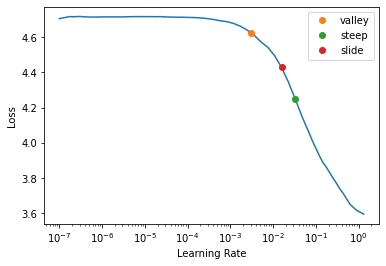

In [15]:
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [17]:
import wandb

from fastai.callback.wandb import WandbCallback

In [14]:
save_at_epoch = 30

In [19]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 3e-2, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}', with_opt=True, save_at_epoch=save_at_epoch),
                                    WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.20758420754763776.
Better model found at epoch 1 with dice_coeff_deep value: 0.6088600978941751.
Better model found at epoch 2 with dice_coeff_deep value: 0.6278040262917175.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 25 with dice_coeff_deep value: 0.6948306337941162.
Saved final mini-run at epoch 30 with dice_coeff_deep value: 0.6948306337941162.


In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [16]:
import wandb

from fastai.callback.wandb import WandbCallback

In [14]:
save_at_epoch = 61
resume_from = 31

In [18]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 3e-2, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 31 with dice_coeff_deep value: 0.6413191536175632.
Better model found at epoch 32 with dice_coeff_deep value: 0.679151492831357.
Better model found at epoch 36 with dice_coeff_deep value: 0.6870521721639882.
Better model found at epoch 43 with dice_coeff_deep value: 0.7004274495162576.
Better model found at epoch 45 with dice_coeff_deep value: 0.7010302778462827.
Better model found at epoch 49 with dice_coeff_deep value: 0.7103620752319876.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Saved final mini-run at epoch 61 with dice_coeff_deep value: 0.7103620752319876.


In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [16]:
import wandb

from fastai.callback.wandb import WandbCallback

In [14]:
save_at_epoch = 92
resume_from = 62

In [18]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 3e-2, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 62 with dice_coeff_deep value: 0.6941670901766381.
Better model found at epoch 63 with dice_coeff_deep value: 0.7011057414463145.
Better model found at epoch 64 with dice_coeff_deep value: 0.7123699725610471.
Better model found at epoch 66 with dice_coeff_deep value: 0.7203883080435399.
Better model found at epoch 67 with dice_coeff_deep value: 0.7253544650908891.
Better model found at epoch 79 with dice_coeff_deep value: 0.7273881998145373.
Better model found at epoch 80 with dice_coeff_deep value: 0.7293843596135992.
Better model found at epoch 82 with dice_coeff_deep value: 0.7295065118118402.


In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [16]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=48, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
learn.dls = dls

In [18]:
learn.export(f'uwmadisonutils/{run}-f{fold}-e{save_at_epoch}.pkl')

In [17]:
import wandb

from fastai.callback.wandb import WandbCallback

In [18]:
save_at_epoch = 99
resume_from = 86

In [19]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
learn.fit_one_cycle(100, 3e-2, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 86 with dice_coeff_deep value: 0.7238566280951304.
Better model found at epoch 87 with dice_coeff_deep value: 0.7258238635526144.
Better model found at epoch 88 with dice_coeff_deep value: 0.7265073446107335.
Saved final mini-run at epoch 99


FileNotFoundError: [Errno 2] No such file or directory: 'models/exp-33-f0-e99.pth'

## exp-32

In [6]:
run = 'exp-32'

In [7]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [8]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomResizedCrop(scale=(0.5, 0.7), height=crop_size, width=crop_size, always_apply=True),
                albumentations.OneOf([
                    albumentations.HorizontalFlip(), 
                    albumentations.VerticalFlip()
                ]),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    # albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.ElasticTransform(),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion()
                    # albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout()
            ])

def get_test_aug(img_size, resize=0.5, crop=0.9):
    crop_size = [round(crop*size) for size in img_size]
    resize = [round(resize*size) for size in crop_size]
    
    if crop < 1.0:
        crop_size = [crop_size[0], crop_size[0]]
        resize = [resize[0], resize[0]]
    
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
        albumentations.Resize(height=resize[0], width=resize[1], always_apply=True)
    ])

### fold 1

In [9]:
tfms_kwargs = dict(train=get_train_aug, test=get_test_aug)

In [10]:
fold = 1

In [11]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.3)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [12]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('regnety_160', channels, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=[GradientAccumulation(64), MixUp(alpha=1.0)])

In [13]:
learn.unfreeze()

In [14]:
7.5*45 / 60

5.625

SuggestedLRs(valley=0.0014454397605732083, steep=0.0063095735386013985, slide=0.0030199517495930195)

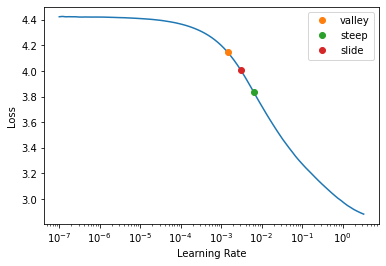

In [15]:
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [18]:
import wandb

from fastai.callback.wandb import WandbCallback

In [16]:
save_at_epoch = 43

In [20]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


In [ ]:
learn.fit_one_cycle(100, 3e-3, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}', with_opt=True, save_at_epoch=save_at_epoch),
                                    WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.05745134663118415.
Better model found at epoch 1 with dice_coeff_deep value: 0.15919707989415235.
Better model found at epoch 2 with dice_coeff_deep value: 0.19821973984055097.
Better model found at epoch 3 with dice_coeff_deep value: 0.2852673530986525.
Better model found at epoch 4 with dice_coeff_deep value: 0.3405444894682055.
Better model found at epoch 5 with dice_coeff_deep value: 0.4190870145058111.
Better model found at epoch 6 with dice_coeff_deep value: 0.4696107020754349.
Better model found at epoch 8 with dice_coeff_deep value: 0.47501142431969107.
Better model found at epoch 10 with dice_coeff_deep value: 0.5471099010621998.
Better model found at epoch 15 with dice_coeff_deep value: 0.5600332825547828.
Better model found at epoch 18 with dice_coeff_deep value: 0.5929293596285333.
Better model found at epoch 21 with dice_coeff_deep value: 0.5958011857752288.
Better model found at epoch 22 with dice_coeff_deep valu

In [17]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [18]:
import wandb

from fastai.callback.wandb import WandbCallback

In [14]:
save_at_epoch = 75
resume_from = 36

In [20]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 3e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 36 with dice_coeff_deep value: 0.6967565233707205.
Better model found at epoch 42 with dice_coeff_deep value: 0.6990301195800511.


In [16]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
learn.dls = dls

In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [19]:
learn.export(f'uwmadisonutils/{run}-f{fold}-e{save_at_epoch}.pkl')

In [16]:
import wandb

from fastai.callback.wandb import WandbCallback

In [14]:
save_at_epoch = 99
resume_from = 79

In [18]:
wandb.init(project="uw-madison models", group=f'{run}', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 3e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 79 with dice_coeff_deep value: 0.7230811717938036.
Better model found at epoch 80 with dice_coeff_deep value: 0.7272582086729703.


In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [16]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
learn.dls = dls

In [21]:
learn.show_results(dl=dls.valid, ds_idx=2, max_n=4)

RuntimeError: CUDA out of memory. Tried to allocate 840.00 MiB (GPU 0; 15.75 GiB total capacity; 5.69 GiB already allocated; 82.31 MiB free; 7.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
learn.export(f'uwmadisonutils/{run}-f{fold}-e{save_at_epoch}.pkl')

In [19]:
learn.validate()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(#3) [0.6101710200309753,0.7214594781799931,0.8373974233366921]

## exp-31

In [7]:
run = 'exp-31'

In [8]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [17]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout()
            ])

def get_test_aug(img_size, resize=0.5, crop=0.9):
    crop_size = [round(crop*size) for size in img_size]
    resize = [round(resize*size) for size in crop_size]
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
        albumentations.Resize(height=resize[0], width=resize[1], always_apply=True)
    ])

### fold 0

In [18]:
tfms_kwargs = dict(train=get_train_aug, test=get_test_aug)

In [19]:
fold = 0

In [20]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [21]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('regnety_160', channels, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=[GradientAccumulation(64), MixUp()])

In [22]:
learn.unfreeze()

In [20]:
7.5*20 / 60

2.5

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0014454397605732083, steep=0.0063095735386013985, slide=0.0030199517495930195)

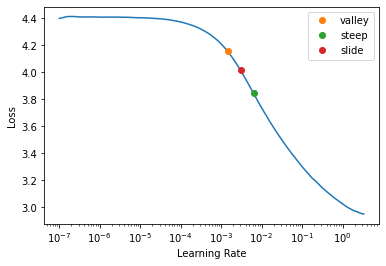

In [17]:
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [21]:
import wandb

from fastai.callback.wandb import WandbCallback

In [17]:
save_at_epoch = 20

In [23]:
wandb.init(project="uw-madison models", group='exp-30', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


In [ ]:
learn.fit_one_cycle(100, 6e-3, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}', with_opt=True, save_at_epoch=save_at_epoch),
                                      WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.35578303307210285.
Better model found at epoch 1 with dice_coeff_deep value: 0.542475598338689.
Better model found at epoch 2 with dice_coeff_deep value: 0.6302427576496806.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 17 with dice_coeff_deep value: 0.6736459488004121.
Saved final mini-run at epoch 20 with dice_coeff_deep value: 0.6736459488004121.


In [18]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [14]:
import wandb

from fastai.callback.wandb import WandbCallback

In [32]:
save_at_epoch = 68
resume_from = 23

In [16]:
wandb.init(project="uw-madison models", group='exp-30', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 6e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 23 with dice_coeff_deep value: 0.660888960057266.
Better model found at epoch 25 with dice_coeff_deep value: 0.6779588599556949.


In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [16]:
learn.export(f'uwmadisonutils/{run}-f{fold}-e{save_at_epoch}.pkl')

In [16]:
import wandb

from fastai.callback.wandb import WandbCallback

In [27]:
save_at_epoch = 99
resume_from = 68

In [18]:
wandb.init(project="uw-madison models", group='exp-30', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
learn.fit_one_cycle(100, 6e-3, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                               with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                                             WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 68 with dice_coeff_deep value: 0.7191236894296695.
Better model found at epoch 70 with dice_coeff_deep value: 0.7290108363546434.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Saved final mini-run at epoch 99 with dice_coeff_deep value: 0.7334617420226966.


In [33]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [34]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=False, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.5)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [35]:
learn.dls = dls

In [36]:
learn.export(f'uwmadisonutils/{run}-f{fold}-e{save_at_epoch}.pkl')

## exp-30

In [6]:
run = 'exp-30'

In [7]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [8]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout()
            ])

### fold 0

In [9]:
tfms_kwargs = dict(train=get_train_aug, test=get_test_aug)

In [10]:
fold = 0

In [11]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, resize=1.0, aug='albumentations',
                          sample_empty=True, empty_frac=0.5, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.4)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('regnety_160', channels, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=[GradientAccumulation(64)])

In [ ]:
learn.unfreeze()

In [17]:
6.5*30 / 60

3.25

SuggestedLRs(valley=0.0014454397605732083, steep=0.0063095735386013985, slide=0.002511886414140463)

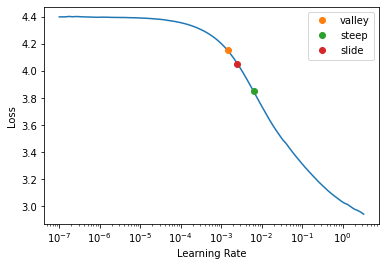

In [22]:
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [14]:
import wandb

from fastai.callback.wandb import WandbCallback

In [14]:
save_at_epoch = 30

In [ ]:
wandb.init(project="uw-madison models", group='exp-30', name=f'{run}-f{fold}-e{save_at_epoch}')

In [ ]:
learn.fit_one_cycle(100, 1e-2, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}', with_opt=True, save_at_epoch=save_at_epoch),
                                      WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.4192668709483984.
Better model found at epoch 1 with dice_coeff_deep value: 0.5827829643723773.
Better model found at epoch 2 with dice_coeff_deep value: 0.6253330680157207.
Better model found at epoch 3 with dice_coeff_deep value: 0.6262733818535324.
Better model found at epoch 6 with dice_coeff_deep value: 0.6383630910858814.
Better model found at epoch 11 with dice_coeff_deep value: 0.6398674563355697.
Better model found at epoch 12 with dice_coeff_deep value: 0.6452700697911871.
Better model found at epoch 15 with dice_coeff_deep value: 0.6757387804327214.
Better model found at epoch 21 with dice_coeff_deep value: 0.680933118362064.
Better model found at epoch 27 with dice_coeff_deep value: 0.6819685970806756.
Saved final mini-run at epoch 30 with dice_coeff_deep value: 0.6819685970806756.


In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [14]:
resume_from = 35
save_at_epoch = 95

In [16]:
import wandb

from fastai.callback.wandb import WandbCallback

wandb.init(project="uw-madison models", group='exp-30', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(100, 1e-2, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                                 with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                      WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 35 with dice_coeff_deep value: 0.6982658286856719.
Better model found at epoch 37 with dice_coeff_deep value: 0.7013692147104713.
Better model found at epoch 43 with dice_coeff_deep value: 0.7026756061907237.
Better model found at epoch 46 with dice_coeff_deep value: 0.7029958675859646.
Better model found at epoch 53 with dice_coeff_deep value: 0.7138262537163352.
Better model found at epoch 54 with dice_coeff_deep value: 0.7189194626625462.
Better model found at epoch 63 with dice_coeff_deep value: 0.7231144944782008.
Better model found at epoch 66 with dice_coeff_deep value: 0.725599153951861.
Better model found at epoch 71 with dice_coeff_deep value: 0.7329720570578331.


In [15]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [16]:
resume_from = 72
save_at_epoch = 99

In [17]:
import wandb

from fastai.callback.wandb import WandbCallback

wandb.init(project="uw-madison models", group='exp-30', name=f'{run}-f{fold}-e{save_at_epoch}')

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


In [18]:
learn.fit_one_cycle(100, 1e-2, start_epoch=resume_from, cbs=[SaveModelCallback('dice_coeff_deep', fname=f'{run}-f{fold}-e{save_at_epoch}',
                                                                                 with_opt=True, save_at_epoch=save_at_epoch, resume_from=resume_from),
                                      WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-e{save_at_epoch}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 72 with dice_coeff_deep value: 0.7145640421780529.
Better model found at epoch 73 with dice_coeff_deep value: 0.7152440373636326.
Better model found at epoch 74 with dice_coeff_deep value: 0.7218931368170681.
Better model found at epoch 75 with dice_coeff_deep value: 0.7265724188536037.
Better model found at epoch 79 with dice_coeff_deep value: 0.7294852490966922.
Better model found at epoch 81 with dice_coeff_deep value: 0.7308155871658581.
Better model found at epoch 85 with dice_coeff_deep value: 0.7319893422875154.
Saved final mini-run at epoch 99 with dice_coeff_deep value: 0.7319893422875154.


In [ ]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=True, empty_frac=0.5, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.4)

In [ ]:
learn.load(f'{run}-f{fold}-e{save_at_epoch}')

In [ ]:
learn.export(f'uwmadisonutils/{run}-f{fold}-e{save_at_epoch}.pkl')

## exp-29

### data

In [5]:
run = 'exp-29'

In [6]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

In [7]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout()
            ])

### fold 0

In [8]:
tfms_kwargs = dict(train=get_train_aug, test=get_test_aug)

In [9]:
fold = 0

In [10]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, resize=1.0, aug='albumentations',
                          sample_empty=True, empty_frac=0.5, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.4)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [11]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=[GradientAccumulation(64)])

In [12]:
learn.unfreeze()

SuggestedLRs(valley=0.001737800776027143, steep=0.005248074419796467, slide=0.0030199517495930195)

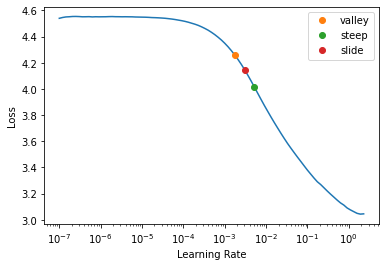

In [13]:
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [13]:
v = 5

In [14]:
import wandb
from fastai.callback.wandb import WandbCallback

wandb.init(project="uw-madison models", group='exp-29', name=f'{run}-f{fold}-v{v}')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
learn.fit_one_cycle(70, 2.2e-2, cbs=[SaveModelCallback('custom_metric_deep', fname=f'{run}-f{fold}-v{v}', with_opt=True),
                                    WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-v{v}')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with custom_metric_deep value: 0.4120118820909913.
Better model found at epoch 1 with custom_metric_deep value: 0.5086704966191333.
Better model found at epoch 2 with custom_metric_deep value: 0.5863269884974642.
Better model found at epoch 4 with custom_metric_deep value: 0.6752633518103555.
Better model found at epoch 5 with custom_metric_deep value: 0.6939602430754728.
Better model found at epoch 10 with custom_metric_deep value: 0.7045572907551071.
Better model found at epoch 11 with custom_metric_deep value: 0.7046107889416147.
Better model found at epoch 13 with custom_metric_deep value: 0.7124629972095071.
Better model found at epoch 15 with custom_metric_deep value: 0.7484150269464181.
Better model found at epoch 23 with custom_metric_deep value: 0.7598198645144167.
Better model found at epoch 31 with custom_metric_deep value: 0.7646392887858459.
Better model found at epoch 32 with custom_metric_deep value: 0.7874706224191145.
Better model found at

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 57 with custom_metric_deep value: 0.8150869350331793.
Better model found at epoch 59 with custom_metric_deep value: 0.8260767731830635.


In [14]:
learn.load(f'{run}-f{fold}-v{v}')

In [15]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=True, empty_frac=0.5, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=0.4)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [16]:
learn.dls = dls

In [18]:
learn.validate()

(#3) [0.4690796434879303,0.7267073155029294,0.8289040549882827]

In [17]:
learn.export(f'uwmadisonutils/{run}-f{fold}-v{v}.pkl')

#### v2

In [13]:
import wandb
from fastai.callback.wandb import WandbCallback

In [15]:
wandb.init(project="uw-madison models", group='exp-29', name=f'{run}-f{fold}-v2.1', resume=True)

In [ ]:
learn.fit_one_cycle(100, 3e-2, start_epoch=50, cbs=[
    SaveModelCallback('custom_metric_deep', every_epoch=True, fname=f'{run}-f{fold}-v1', with_opt=True),
    WandbCallback(log_preds=False, model_name=f'{run}-f{fold}-v1')])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.save(f'{run}-f{fold}-v2')

In [ ]:
learn.export(f'uwmadisonutils/{run}-f{fold}-v2.pkl')

In [ ]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=1.0, resize=1.0, aug='albumentations',
                          sample_empty=True, empty_frac=0.5, val='group', fold=fold, tfms_kwargs=tfms_kwargs,
                          show=False, aug_p=1.0)

In [ ]:
learn.dls = dls

In [ ]:
learn.validate()

## exp-28-mini

### data

In [18]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

### fold 1

In [19]:
tfms_kwargs = dict(mult=1.2, max_lighting=0.2, flip_vert=True)

dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.8, val_crop=1.0, resize=0.5,
                          sample_empty=False, val='group', fold=1, show=False, tfms_kwargs=tfms_kwargs)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
def deep_supervision_loss(inp, targ, loss_func=ComboLoss()):
    loss = 0
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

In [20]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           custom_metric_deep,
                           cbs=[GradientAccumulation(64)])

In [9]:
import wandb
from fastai.callback.wandb import WandbCallback

In [10]:
wandb.init(project="uw-madison models", group='exp-28-mini', name=f'exp-28-mini-f0')

wandb: Currently logged in as: ahmedsamirio. Use `wandb login --relogin` to force relogin


In [11]:
learn.fit_one_cycle(80, 1e-2, cbs=[SaveModelCallback('custom_metric_deep', fname='exp-28-mini-f1-v1.0', with_opt=True),
                                   WandbCallback(log_preds=False, model_name="exp-28-mini-f1-v1")])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with custom_metric_deep value: 0.4248301736016771.
Better model found at epoch 1 with custom_metric_deep value: 0.42842728943881747.
Better model found at epoch 3 with custom_metric_deep value: 0.4952421207066187.
Better model found at epoch 5 with custom_metric_deep value: 0.4974508878397879.
Better model found at epoch 6 with custom_metric_deep value: 0.5642147723018172.
Better model found at epoch 11 with custom_metric_deep value: 0.6162997238325753.
Better model found at epoch 12 with custom_metric_deep value: 0.6421257061031941.
Better model found at epoch 17 with custom_metric_deep value: 0.665146674735668.
Better model found at epoch 18 with custom_metric_deep value: 0.6939427990252612.
Better model found at epoch 22 with custom_metric_deep value: 0.7090424201828942.
Better model found at epoch 33 with custom_metric_deep value: 0.7295942160508896.
Better model found at epoch 37 with custom_metric_deep value: 0.7300460232974826.
Better model found at

In [21]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=16, crop=0.8, val_crop=1.0, resize=1.0,
                          sample_empty=False, val='group', fold=1, show=False, tfms_kwargs=tfms_kwargs)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [10]:
learn.dls = dls

In [14]:
learn.validate()

(#2) [2.0062191486358643,0.5550745937873974]

SuggestedLRs(valley=0.001737800776027143)

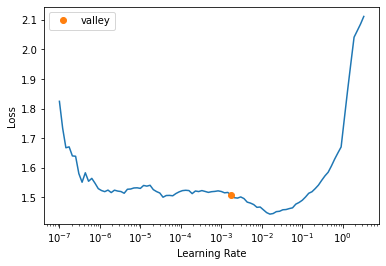

In [15]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.show_results(max_n=8)

In [16]:
learn.fine_tune(2, 2e-3)

KeyboardInterrupt: 

In [22]:
learn.load('exp-28-f0-v1.0')

FileNotFoundError: [Errno 2] No such file or directory: 'models/exp-28-f0-v1.0.pth'

In [16]:
def get_train_aug(img_size, crop=0.9, resize=0.5, p=0.4):
    crop_size = round(img_size[0]*crop)
    resize = round(crop_size*resize)
    return albumentations.Compose([
            albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.HorizontalFlip(p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            albumentations.Resize(height=resize, width=resize, always_apply=True)
            ])


def get_test_aug(img_size, resize=0.5, crop=0.9):
    crop_size = round(crop*img_size[0])
    resize = round(crop_size*resize)
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size, width=crop_size, always_apply=True),
        albumentations.Resize(height=resize, width=resize, always_apply=True)
    ])

In [7]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.8, val_crop=1.0, resize=0.5,
                          sample_empty=False, val='group', fold=1, show=False, aug='albumentations')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           custom_metric_deep,
                           cbs=[GradientAccumulation(64)])

In [9]:
learn.load('exp-28-f0-v1.0')

In [10]:
learn.export('uwmadisonutils/exp-28-f0-v1.0.pkl')

## exp-26 

### data

In [7]:
channels = 3
stride = 2

train = pd.read_csv(data_path+'train.csv', low_memory=False)
train = get_custom_df(train, train_fnames, str(train_path), channels=channels, stride=stride)

### train aug

In [8]:
def get_train_aug(img_size, crop=0.9, p=0.4):
    crop_size = round(img_size[0]*crop)
    return albumentations.Compose([
                albumentations.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
                albumentations.HorizontalFlip(),
                albumentations.OneOf([
                    albumentations.Sharpen(),
                    albumentations.Emboss(),
                    albumentations.RandomGamma(),
                    albumentations.RandomBrightnessContrast(),
                    ], p=p),
                albumentations.OneOf([
                    albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                    albumentations.GridDistortion(),
                    albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
                    
                    ], p=p),
                albumentations.ShiftScaleRotate(),
                albumentations.CoarseDropout()
            ])

### testing loss function config

In [10]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=32, crop=0.5, val_crop=1.0, aug_p=0.4, sample=True,
                          sample_empty=True, empty_frac=0.5, val='group', fold=0, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [11]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b0', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[1, 3, 3])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=GradientAccumulation(64))

In [12]:
learn.fine_tune(1, 1e-2)

In [13]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b0', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[3, 1, 3])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=GradientAccumulation(64))

In [14]:
learn.fine_tune(1, 1e-2)

In [15]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b0', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[3, 3, 1])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=GradientAccumulation(64))

In [16]:
learn.fine_tune(1, 1e-2)

In [17]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b0', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 3, 1])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=GradientAccumulation(64))

In [18]:
learn.fine_tune(1, 1e-2)

### Wandb

In [9]:
from fastai.callback.wandb import WandbCallback

In [10]:
import wandb
from fastai.callback.wandb import WandbCallback

wandb.init(project="uw-madison models", group="exp-26-v2")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### fold 0

#### v1

In [10]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, aug_p=0.4,
                          sample_empty=True, empty_frac=0.5, val='group', fold=0, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [11]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 3, 1])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=[GradientAccumulation(64)])

SuggestedLRs(valley=0.0014454397605732083)

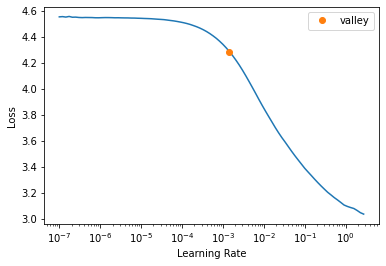

In [13]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(60, 1e-2, cbs=[SaveModelCallback('dice_coeff_deep', fname='exp-26-f0-v1.0', with_opt=True),
                                   WandbCallback(log_preds=False, model_name="exp-26-f0-v1")])

Better model found at epoch 0 with dice_coeff_deep value: 0.0.
Better model found at epoch 1 with dice_coeff_deep value: 0.34001303325633747.
Better model found at epoch 2 with dice_coeff_deep value: 0.45418756041027236.


In [17]:
learn.export('uwmadisonutils/exp-26-f0-v1.0.pkl')

#### v2

In [14]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=8, crop=0.9, val_crop=0.9, aug_p=0.4,
                          sample_empty=False, val='group', fold=0, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [15]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 3, 1])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=[GradientAccumulation(64)])

In [16]:
learn.load('exp-26-f0-v1.0')

SuggestedLRs(valley=0.009120108559727669)

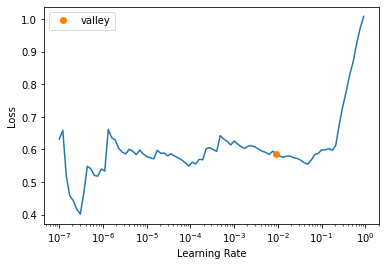

In [13]:
learn.unfreeze()
learn.lr_find()

In [20]:
learn.fit_one_cycle(15, 1e-4, cbs=[SaveModelCallback('dice_coeff_deep', fname='exp-26-f0-v2.0', with_opt=True),
                                   WandbCallback(log_preds=False, model_name="exp-26-f0-v2")])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.7058953541156152.
Better model found at epoch 1 with dice_coeff_deep value: 0.7146311133333267.
Better model found at epoch 2 with dice_coeff_deep value: 0.714681978867178.
Better model found at epoch 3 with dice_coeff_deep value: 0.716716714976279.
Better model found at epoch 5 with dice_coeff_deep value: 0.7206422955823801.


### fold 1

#### v1

In [12]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, aug_p=0.4,
                          sample_empty=True, empty_frac=0.5, val='group', fold=1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [13]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=[GradientAccumulation(64)])

SuggestedLRs(valley=0.0020892962347716093)

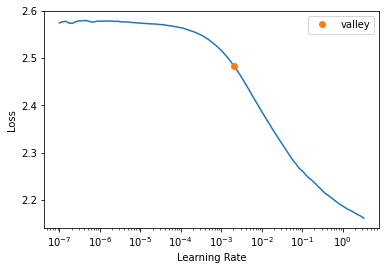

In [14]:
learn.unfreeze()
learn.lr_find()

In [15]:
learn.fit_one_cycle(60, 2e-2, cbs=[SaveModelCallback('dice_coeff_deep', fname='exp-26-f1-v1.0', with_opt=True),
                                   WandbCallback(log_preds=False, model_name="exp-26-f1-v1")])

Better model found at epoch 0 with dice_coeff_deep value: 0.20575303702125652.
Better model found at epoch 1 with dice_coeff_deep value: 0.4341209526420786.
Better model found at epoch 2 with dice_coeff_deep value: 0.49178015812265746.
Better model found at epoch 3 with dice_coeff_deep value: 0.5023043435826882.
Better model found at epoch 4 with dice_coeff_deep value: 0.5185781109027254.
Better model found at epoch 5 with dice_coeff_deep value: 0.5836535542042589.
Better model found at epoch 7 with dice_coeff_deep value: 0.5933529356597327.
Better model found at epoch 10 with dice_coeff_deep value: 0.6000949518820283.
Better model found at epoch 14 with dice_coeff_deep value: 0.6129573389076736.
Better model found at epoch 16 with dice_coeff_deep value: 0.650640138373151.
Better model found at epoch 18 with dice_coeff_deep value: 0.6625408199704045.
Better model found at epoch 19 with dice_coeff_deep value: 0.6660090483038029.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 37 with dice_coeff_deep value: 0.7130380287878706.
Better model found at epoch 38 with dice_coeff_deep value: 0.713240458764623.
Better model found at epoch 40 with dice_coeff_deep value: 0.7187885486972153.
Better model found at epoch 41 with dice_coeff_deep value: 0.7223185322258626.
Better model found at epoch 43 with dice_coeff_deep value: 0.7242676461216316.
Better model found at epoch 44 with dice_coeff_deep value: 0.7321685402712386.
Better model found at epoch 49 with dice_coeff_deep value: 0.7331924529699234.
Better model found at epoch 50 with dice_coeff_deep value: 0.7341914620082179.
Better model found at epoch 51 with dice_coeff_deep value: 0.7365984852749281.
Better model found at epoch 52 with dice_coeff_deep value: 0.7393135194787658.


In [16]:
learn.save('exp-26-f1-v1.1')

Path('models/exp-26-f1-v1.1.pth')

In [17]:
learn.load('exp-26-f1-v1.1')

In [18]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=32, crop=0.5, val_crop=1.0, aug_p=0.4,
                          sample_empty=True, empty_frac=0.5, val='group', fold=1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [19]:
learn.dls = dls

In [20]:
learn.validate()

(#2) [0.30838245153427124,0.796748337323968]

In [21]:
learn.load('exp-26-f1-v1.0')

In [22]:
learn.validate()

(#2) [0.30838245153427124,0.796748337323968]

In [23]:
learn.export('uwmadisonutils/exp-26-f1-v1.0.pkl')

#### v2

In [11]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=32, crop=0.9, val_crop=0.9, aug_p=0.4,
                          sample_empty=False, val='group', fold=1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [12]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=[GradientAccumulation(64)],
                           opt_func=ranger)

In [13]:
learn.load('exp-26-f1-v1.0')

/notebooks/fastai/fastai/learner.py:60: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(valley=0.002511886414140463)

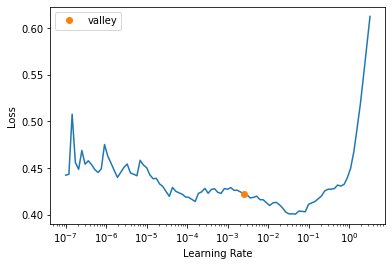

In [14]:
# learn.unfreeze()
learn.lr_find()

SuggestedLRs(valley=0.0006918309954926372)

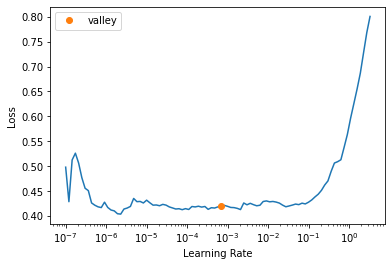

In [15]:
learn.unfreeze()
learn.lr_find()

In [16]:
learn.freeze()

In [17]:
learn.fit_flat_cos(1, 1e-5, cbs=[SaveModelCallback('dice_coeff_deep', fname='exp-26-f1-v2.0', with_opt=False),
                                   WandbCallback(log_preds=False, model_name="exp-26-f1-v2")])

Better model found at epoch 0 with dice_coeff_deep value: 0.7171441402532602.


In [18]:
learn.unfreeze()

In [19]:
learn.fit_flat_cos(1, slice(1e-7, 1e-5), cbs=[SaveModelCallback('dice_coeff_deep', fname='exp-26-f1-v2.0', with_opt=False),
                                              WandbCallback(log_preds=False, model_name="exp-26-f1-v2")])

Better model found at epoch 0 with dice_coeff_deep value: 0.7203485850771086.


### fold 2

In [12]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, aug_p=0.4,
                          sample_empty=True, empty_frac=0.5, val='group', fold=2, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [13]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 3, 1])),
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=[GradientAccumulation(64)])

SuggestedLRs(valley=0.0020892962347716093)

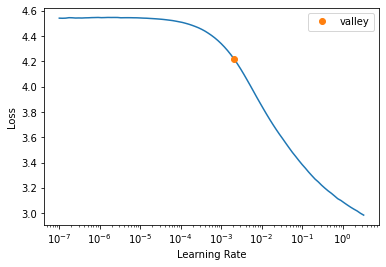

In [13]:
learn.unfreeze()
learn.lr_find()

In [14]:
learn.fit_one_cycle(60, 2e-2, cbs=[SaveModelCallback('dice_coeff_deep', fname='exp-26-f2-v1.0', with_opt=True),
                                   WandbCallback(log_preds=False, model_name="exp-26-f2-v1")])

Better model found at epoch 0 with dice_coeff_deep value: 0.14684143593889146.
Better model found at epoch 1 with dice_coeff_deep value: 0.44885933653851545.
Better model found at epoch 2 with dice_coeff_deep value: 0.520629731467482.
Better model found at epoch 3 with dice_coeff_deep value: 0.5355957262925511.
Better model found at epoch 4 with dice_coeff_deep value: 0.57882240532721.
Better model found at epoch 6 with dice_coeff_deep value: 0.5879530827565304.
Better model found at epoch 9 with dice_coeff_deep value: 0.6183215468813257.
Better model found at epoch 13 with dice_coeff_deep value: 0.6477068836545152.
Better model found at epoch 14 with dice_coeff_deep value: 0.6699676184515309.
Better model found at epoch 20 with dice_coeff_deep value: 0.6726643709340427.
Better model found at epoch 23 with dice_coeff_deep value: 0.6821251596913402.
Better model found at epoch 24 with dice_coeff_deep value: 0.687077241725558.
Better model found at epoch 25 with dice_coeff_deep value: 0.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 44 with dice_coeff_deep value: 0.7370832754483342.
Better model found at epoch 49 with dice_coeff_deep value: 0.7372141821322193.
Better model found at epoch 54 with dice_coeff_deep value: 0.7402849376653645.


In [15]:
learn.save('exp-26-f2-v1.1')

Path('models/exp-26-f2-v1.1.pth')

In [14]:
learn.load('exp-26-f2-v1.1')

In [16]:
learn.export('uwmadisonutils/exp-26-f2-v1.1.pkl')

In [17]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=32, crop=0.5, val_crop=1.0, aug_p=0.4,
                          sample_empty=False, val='group', fold=2, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [18]:
learn.dls = dls

In [19]:
learn.validate()

(#2) [0.46449223160743713,0.7402241973536924]

#### Validate es v1

In [22]:
learn = learn.load('exp-26-f2-v1.0')

In [24]:
learn.export('uwmadisonutils/exp-26-f2-v1.0.pkl')

Error in callback <function _WandbInit._resume_backend at 0x7fd7cf9a3700> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7fd7cf9a3790> (for post_run_cell):


Exception: The wandb backend process has shutdown

Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 170, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 127, in communicate_stop_status
    resp = self._communicate_stop_status(status)
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/interface/interface_shared.py", line 395, in _communicate_stop_status
    resp = self._communicate(req, local=True)
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/interface/interface_shared.py", line 226, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/opt/conda/lib/python3.8/site

### fold 3

In [10]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, aug_p=0.4,
                          sample_empty=True, empty_frac=0.3, val='group', fold=3, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [11]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b6', channels, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=[GradientAccumulation(64)])

SuggestedLRs(valley=0.0020892962347716093)

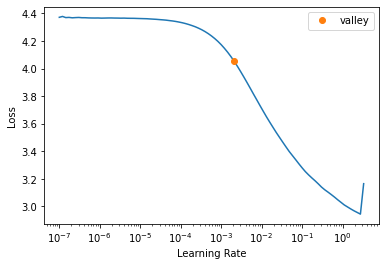

In [13]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(60, 2e-2, cbs=[SaveModelCallback('dice_coeff_deep', fname='exp-26-f3-v1.0', with_opt=True),
                                   WandbCallback(log_preds=False, model_name="exp-26-f3-v1")])

Better model found at epoch 0 with dice_coeff_deep value: 0.22567631481343545.
Better model found at epoch 3 with dice_coeff_deep value: 0.5330465991813003.
Better model found at epoch 6 with dice_coeff_deep value: 0.5421603837875965.
Better model found at epoch 7 with dice_coeff_deep value: 0.5834782907323454.
Better model found at epoch 8 with dice_coeff_deep value: 0.6292787742143413.
Better model found at epoch 14 with dice_coeff_deep value: 0.6564459732721218.
Better model found at epoch 15 with dice_coeff_deep value: 0.6666536224622365.
Better model found at epoch 18 with dice_coeff_deep value: 0.673312020575953.
Better model found at epoch 19 with dice_coeff_deep value: 0.6744251522057427.


In [12]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=32, crop=0.5, val_crop=1.0, aug_p=0.4,
                          sample_empty=False, val='group', fold=3, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [13]:
learn.dls = dls

In [14]:
learn.load('exp-26-f3-v1.0')

In [ ]:
learn.validate()

In [ ]:
learn.export('uwmadisonutils/exp-26-f3-v1.0.pkl')

### fold 4

In [9]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=64, crop=0.6, val_crop=0.6, aug_p=0.4,
                          sample_empty=True, empty_frac=0.5, val='group', fold=4, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [10]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', channels, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep],
                           cbs=[GradientAccumulation(64)])

SuggestedLRs(valley=0.0020892962347716093, steep=0.005248074419796467, slide=0.0030199517495930195)

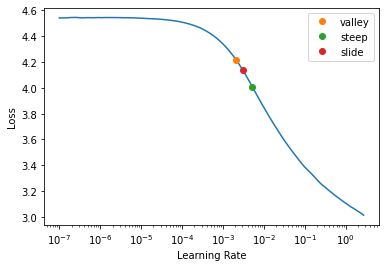

In [11]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[SuggestionMethod.Valley, SuggestionMethod.Steep, SuggestionMethod.Slide])

In [ ]:
learn.fit_one_cycle(70, 2e-2, cbs=[SaveModelCallback('dice_coeff_deep', fname='exp-26-f4-v1.0', at_end=True, with_opt=True),
                                   WandbCallback(log_preds=False, model_name="exp-26-f4-v1", seed=42)])

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.1375568280633569.
Better model found at epoch 1 with dice_coeff_deep value: 0.3896097275642786.
Better model found at epoch 2 with dice_coeff_deep value: 0.5093035922153891.
Better model found at epoch 3 with dice_coeff_deep value: 0.510435463847517.
Better model found at epoch 4 with dice_coeff_deep value: 0.5512175690326467.
Better model found at epoch 6 with dice_coeff_deep value: 0.573629450259848.
Better model found at epoch 10 with dice_coeff_deep value: 0.5745134031733978.
Better model found at epoch 11 with dice_coeff_deep value: 0.5820583834055973.
Better model found at epoch 12 with dice_coeff_deep value: 0.6078580081725099.
Better model found at epoch 13 with dice_coeff_deep value: 0.6092706385152885.
Better model found at epoch 14 with dice_coeff_deep value: 0.6372206644697556.
Better model found at epoch 17 with dice_coeff_deep value: 0.6609111852477714.
Better model found at epoch 20 with dice_coeff_deep value: 0

In [ ]:
dls, dev = get_5C_25D_dls(train, channels=channels, bs=32, crop=0.5, val_crop=1.0, aug_p=0.4,
                          sample_empty=False, val='group', fold=4, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.load('exp-26-f4-v1.0')

In [ ]:
learn.validate()

In [ ]:
learn.export('uwmadisonutils/exp-26-f4-v1.0.pkl')

## exp-25 custom validation

In [6]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.5, val_crop=0.2, aug_p=0.4, sample_empty=True, empty_frac=0.5, val='custom', show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [dice_coeff_deep])

In [8]:
learn.unfreeze()

SuggestedLRs(valley=0.0020892962347716093)

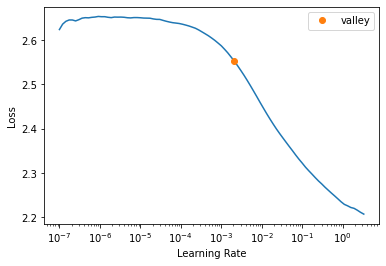

In [9]:
learn.lr_find()

In [10]:
340/4.75

71.57894736842105

In [11]:
learn.fit_one_cycle(70, 1e-2, cbs=SaveModelCallback(at_end=True, fname='exp-25-v1.0.1'))

Better model found at epoch 0 with valid_loss value: 2.017745018005371.
Better model found at epoch 1 with valid_loss value: 1.8002029657363892.
Better model found at epoch 2 with valid_loss value: 1.7127997875213623.
Better model found at epoch 4 with valid_loss value: 1.7029496431350708.
Better model found at epoch 5 with valid_loss value: 1.6359909772872925.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 12 with valid_loss value: 1.245008111000061.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 24 with valid_loss value: 1.061179757118225.
Better model found at epoch 27 with valid_loss value: 1.0088534355163574.
Better model found at epoch 35 with valid_loss value: 0.9766094088554382.
Better model found at epoch 41 with valid_loss value: 0.9494665265083313.
Better model found at epoch 42 with valid_loss value: 0.9420685172080994.
Better model found at epoch 43 with valid_loss value: 0.9416267275810242.
Better model found at epoch 44 with valid_loss value: 0.890659749507904.
Better model found at epoch 48 with valid_loss value: 0.8747289180755615.
Better model found at epoch 49 with valid_loss value: 0.873273491859436.
Better model found at epoch 50 with valid_loss value: 0.8563255071640015.
Better model found at epoch 56 with valid_loss value: 0.8352058529853821.
Better model found at epoch 57 with valid_loss value: 0.8313975930213928.
Better model found at epoch 58 with valid_loss value: 0.8098141551017761.
Better model found at epoch 64 with valid

In [8]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, val_crop=1.0, aug_p=0.4, sample_empty=False, show=False, val='custom')

In [9]:
learn.dls = dls

In [14]:
learn.validate()

(#2) [0.3943839967250824,0.7567651381292434]

In [15]:
learn.load('exp-23-v1.0.1')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [16]:
learn.export('uwmadisonutils/exp-23-v1.0.1.pkl')

In [10]:
learn.export('uwmadisonutils/exp-25-v1.0.1.pkl')

## exp-23 custom validation

In [11]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, val_crop=0.2, aug_p=0.4, sample_empty=True, empty_frac=0.1, show=False, val='custom')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [12]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


In [8]:
learn.unfreeze()

SuggestedLRs(valley=0.001737800776027143)

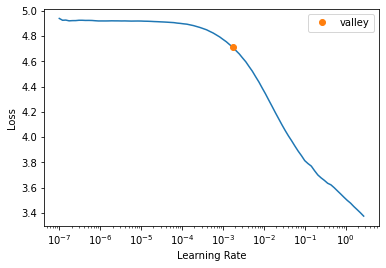

In [9]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(80, 1e-2, cbs=SaveModelCallback(monitor='dice_coeff_deep', at_end=True, fname='exp-23-v1.0.1'))

Better model found at epoch 1 with dice_coeff_deep value: 0.19709016785219005.
Better model found at epoch 2 with dice_coeff_deep value: 0.2597186675599322.
Better model found at epoch 3 with dice_coeff_deep value: 0.28025564614631016.
Better model found at epoch 4 with dice_coeff_deep value: 0.31099558971949265.
Better model found at epoch 5 with dice_coeff_deep value: 0.34270363734219006.
Better model found at epoch 11 with dice_coeff_deep value: 0.34314269684006504.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 46 with dice_coeff_deep value: 0.45730414136559394.
Better model found at epoch 73 with dice_coeff_deep value: 0.5149439095245187.


In [13]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, val_crop=1.0, aug_p=0.4, sample_empty=False, show=False, val='custom')

In [14]:
learn.dls = dls

In [ ]:
learn.validate()

In [15]:
learn.load('exp-23-v1.0.1')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [16]:
learn.export('uwmadisonutils/exp-23-v1.0.1.pkl')

## exp-25

In [6]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.5, val_crop=0.2, aug_p=0.4, sample_empty=True, empty_frac=0.5, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [dice_coeff_deep])

In [8]:
learn.unfreeze()

SuggestedLRs(valley=0.001737800776027143)

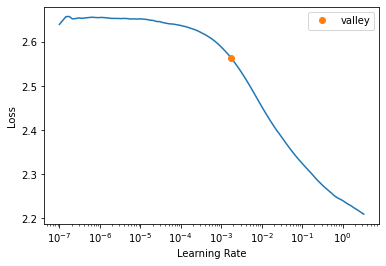

In [9]:
learn.lr_find()

In [10]:
340/5.5

61.81818181818182

In [ ]:
learn.fit_one_cycle(60, 1e-2, cbs=SaveModelCallback(at_end=True, fname='exp-25-v1.0'))

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with valid_loss value: 1.9787942171096802.
Better model found at epoch 2 with valid_loss value: 1.7325043678283691.


In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, val_crop=1.0, aug_p=0.4, sample_empty=False, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.validate()

In [ ]:
learn.export('uwmadisonutils/exp-25-v1.0.pkl')

## exp-24

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.6, val_crop=0.4, aug_p=0.4, sample_empty=True, empty_frac=0.1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b7', 5, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64))

In [11]:
learn.unfreeze()

SuggestedLRs(valley=0.0020892962347716093)

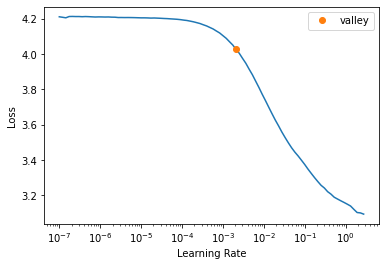

In [12]:
learn.lr_find()

In [14]:
340/5

68.0

In [ ]:
learn.fit_one_cycle(65, 1e-2, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-24-v1.0'))

Better model found at epoch 0 with dice_coeff_deep value: 0.0.
Better model found at epoch 2 with dice_coeff_deep value: 0.3701901427145996.
Better model found at epoch 3 with dice_coeff_deep value: 0.3882420817479198.
Better model found at epoch 4 with dice_coeff_deep value: 0.47781778242010775.
Better model found at epoch 7 with dice_coeff_deep value: 0.5328118318480863.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 18 with dice_coeff_deep value: 0.6204090275295737.
Better model found at epoch 20 with dice_coeff_deep value: 0.6322634888263663.
Better model found at epoch 25 with dice_coeff_deep value: 0.660342027090198.
Better model found at epoch 39 with dice_coeff_deep value: 0.6631888916981407.
Better model found at epoch 48 with dice_coeff_deep value: 0.6766156076675767.
Better model found at epoch 58 with dice_coeff_deep value: 0.6772211118628941.


In [ ]:
learn.recorder.plot_loss()

In [8]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.6, val_crop=1.0, aug_p=0.4, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [9]:
learn.dls = dls

In [10]:
learn.load('exp-24-v1.0')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [11]:
learn.export('uwmadisonutils/exp-24-v1.0.pkl')

In [12]:
learn.validate()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(#3) [0.4767550528049469,0.7164256199954584,0.8082176879354502]

In [12]:
!./update-dataset.sh

Starting upload for file exp-17-v3.1
100%|████████████████████████████████████████| 137M/137M [00:02<00:00, 65.0MB/s]
Upload successful: exp-17-v3.1 (137MB)
Skipping folder: tmpa4766qnz; use '--dir-mode' to upload folders
Starting upload for file exp-12-v4.pkl
100%|████████████████████████████████████████| 121M/121M [00:01<00:00, 67.7MB/s]
Upload successful: exp-12-v4.pkl (121MB)
Starting upload for file __init__.py
0.00B [00:00, ?B/s]
Upload successful: __init__.py (0B)
Starting upload for file exp-22-v1.0.pkl
100%|████████████████████████████████████████| 113M/113M [00:01<00:00, 68.7MB/s]
Upload successful: exp-22-v1.0.pkl (113MB)
Skipping folder: tmpc2r_mi8r; use '--dir-mode' to upload folders
Starting upload for file utilities.py
100%|███████████████████████████████████████| 51.5k/51.5k [00:00<00:00, 106kB/s]
Upload successful: utilities.py (51KB)
Starting upload for file exp-21-v1.0.pkl
100%|████████████████████████████████████████| 112M/112M [00:01<00:00, 68.7MB/s]
Upload success

## exp-23

This experiment is an attempt to replicate the results of exp-18 but with longer training.

### v1

In [6]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.6, val_crop=0.5, aug_p=0.4, sample_empty=True, empty_frac=0.1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep])

In [9]:
learn.unfreeze()

SuggestedLRs(valley=0.0014454397605732083)

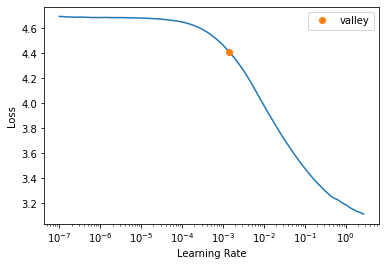

In [10]:
learn.lr_find()

In [11]:
340/4.25

80.0

In [12]:
learn.fit_one_cycle(80, 1e-2, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-23-v1.0'))

Better model found at epoch 0 with dice_coeff_deep value: 0.36797404257616095.
Better model found at epoch 1 with dice_coeff_deep value: 0.544182306875162.
Better model found at epoch 2 with dice_coeff_deep value: 0.5707254440473384.
Better model found at epoch 3 with dice_coeff_deep value: 0.5974433523148327.
Better model found at epoch 4 with dice_coeff_deep value: 0.6086155154415055.
Better model found at epoch 7 with dice_coeff_deep value: 0.6191606906496111.
Better model found at epoch 8 with dice_coeff_deep value: 0.6199658421561456.
Better model found at epoch 14 with dice_coeff_deep value: 0.6277037232869657.
Better model found at epoch 17 with dice_coeff_deep value: 0.6365277439955696.
Better model found at epoch 19 with dice_coeff_deep value: 0.6497634510911916.
Better model found at epoch 22 with dice_coeff_deep value: 0.6799818560499993.
Better model found at epoch 30 with dice_coeff_deep value: 0.6852294302023682.
Better model found at epoch 33 with dice_coeff_deep value: 

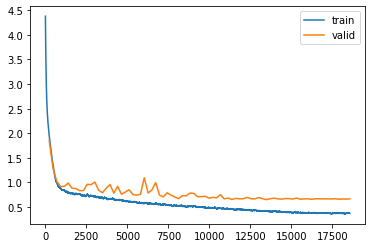

In [14]:
learn.recorder.plot_loss()

In [8]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.6, val_crop=1.0, aug_p=0.4, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [9]:
learn.dls = dls

In [17]:
learn.save('exp-23-v1.1')

Path('models/exp-23-v1.1.pth')

In [18]:
learn.export('uwmadisonutils/exp-23-v1.1.pkl')

In [10]:
learn.load('exp-23-v1.0')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [20]:
learn.export('uwmadisonutils/exp-23-v1.0.pkl')

#### v1.0 validation

In [11]:
learn.validate()

(#3) [0.4972556233406067,0.716933050380542,0.8097809358842024]

In [ ]:
learn.load('exp-23-v1.1')

#### v1.1 validation

In [ ]:
learn.validate()

In [ ]:
!./update-dataset.sh

Starting upload for file exp-17-v3.1
100%|████████████████████████████████████████| 137M/137M [00:31<00:00, 4.64MB/s]
Upload successful: exp-17-v3.1 (137MB)
Skipping folder: tmpa4766qnz; use '--dir-mode' to upload folders
Starting upload for file exp-12-v4.pkl
100%|████████████████████████████████████████| 121M/121M [00:28<00:00, 4.41MB/s]
Upload successful: exp-12-v4.pkl (121MB)
Starting upload for file __init__.py
0.00B [00:00, ?B/s]
Upload successful: __init__.py (0B)
Starting upload for file exp-22-v1.0.pkl
100%|████████████████████████████████████████| 113M/113M [00:19<00:00, 5.93MB/s]
Upload successful: exp-22-v1.0.pkl (113MB)
Skipping folder: tmpc2r_mi8r; use '--dir-mode' to upload folders
Starting upload for file utilities.py
100%|███████████████████████████████████████| 51.5k/51.5k [00:00<00:00, 108kB/s]
Upload successful: utilities.py (51KB)
Starting upload for file exp-21-v1.0.pkl
100%|████████████████████████████████████████| 112M/112M [00:19<00:00, 6.20MB/s]
Upload success

### v2

In [8]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.9, val_crop=0.6, aug_p=0.4, sample_empty=True, empty_frac=0.1, show=False)

NameError: name 'get_5C_25D_dls' is not defined

In [9]:
def deep_supervision_loss(inp, targ, loss_func):
    loss = 0
    for i in range(len(inp)):
        loss += loss_func(inp[i], targ)
    return loss/len(inp)

In [8]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=True),
                           partial(deep_supervision_loss, loss_func=ComboLoss(ws=[2, 1, 0])),
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep])

In [9]:
learn.load('exp-23-v1.1')

In [10]:
learn.freeze()

SuggestedLRs(valley=0.0002290867705596611)

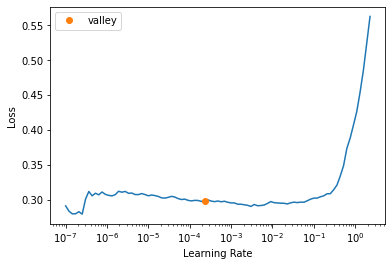

In [11]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(20, 1e-3, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-23-v2.0'))

Better model found at epoch 0 with dice_coeff_deep value: 0.7125856053951254.
Better model found at epoch 3 with dice_coeff_deep value: 0.713658622754186.
Better model found at epoch 6 with dice_coeff_deep value: 0.7139906589222428.
Better model found at epoch 11 with dice_coeff_deep value: 0.7146111069966353.
Better model found at epoch 12 with dice_coeff_deep value: 0.716967483656091.
Better model found at epoch 14 with dice_coeff_deep value: 0.7173887229803845.
Better model found at epoch 16 with dice_coeff_deep value: 0.7178709507627618.


In [14]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(20, slice(1e-6, 1e-4), cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-23-v2.1'))

Better model found at epoch 0 with dice_coeff_deep value: 0.7142103028175749.
Better model found at epoch 1 with dice_coeff_deep value: 0.7175269355751657.


## exp-22

Train an efficientnet b5 with progressive resizing but with full dataset and test on kaggle.

### v1

In [10]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.6, val_crop=0.6, aug_p=0.4, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [11]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           # cbs=GradientAccumulation(64)
                          )

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


In [12]:
learn.unfreeze()

SuggestedLRs(valley=0.002511886414140463)

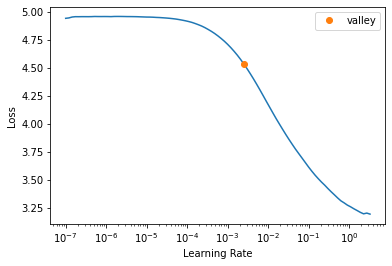

In [13]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(40, 1e-2, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-22-v1.0'))

Better model found at epoch 0 with dice_coeff_deep value: 0.0.
Better model found at epoch 1 with dice_coeff_deep value: 0.6020892436280676.
Better model found at epoch 4 with dice_coeff_deep value: 0.6614816682062319.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 16 with dice_coeff_deep value: 0.6856734279355997.
Better model found at epoch 20 with dice_coeff_deep value: 0.6950527364954832.
Better model found at epoch 24 with dice_coeff_deep value: 0.6989069703069241.
Better model found at epoch 25 with dice_coeff_deep value: 0.7125110585290089.
Better model found at epoch 34 with dice_coeff_deep value: 0.7145256465614368.


In [18]:
learn.export('uwmadisonutils/exp-22-v1.1.pkl')

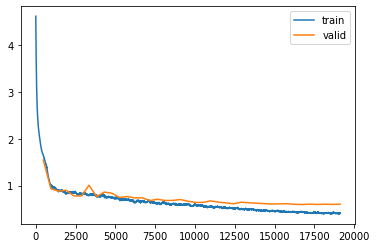

In [16]:
learn.recorder.plot_loss()

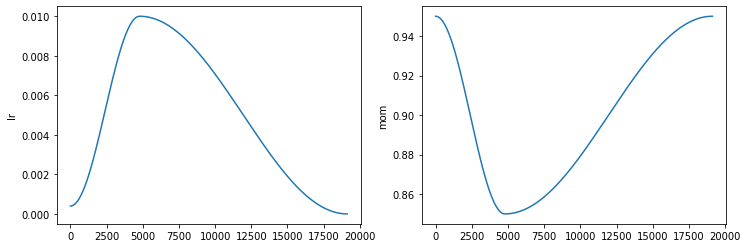

In [17]:
learn.recorder.plot_sched()

In [19]:
learn.load('exp-22-v1.0')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [20]:
learn.export('uwmadisonutils/exp-22-v1.0.pkl')

In [21]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.6, val_crop=1.0, aug_p=0.4, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [22]:
learn.dls = dls

In [24]:
learn.export('uwmadisonutils/exp-22-v1.0.pkl')

In [23]:
learn.validate()

(#3) [0.4835476875305176,0.7147635722974437,0.8261407230423751]

### v2

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.9, val_crop=0.6, aug_p=0.4, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64)
                          )

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


In [8]:
learn.load('exp-22-v1.0')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [9]:
learn.freeze()

SuggestedLRs(valley=7.585775892948732e-05)

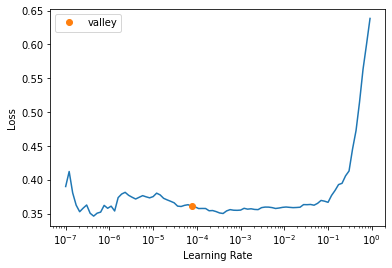

In [10]:
learn.lr_find()

In [ ]:
learn.fine_tune(20, 1e-4, lr_mult=10, freeze_epochs=5, cbs= SaveModelCallback(monitor='custom_metric_deep', fname='exp-22-v2.0'))

Better model found at epoch 0 with custom_metric_deep value: 0.8074043144945503.
Better model found at epoch 1 with custom_metric_deep value: 0.8096909650328544.
Better model found at epoch 2 with custom_metric_deep value: 0.8100701921393574.
Better model found at epoch 3 with custom_metric_deep value: 0.8117554768931854.
Better model found at epoch 4 with custom_metric_deep value: 0.8126100913124849.


Better model found at epoch 0 with custom_metric_deep value: 0.8134718505962069.


In [ ]:
learn.save('exp-22-v2.1')

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.9, val_crop=1.0, aug_p=0.4, sample_empty=False, show=False)

In [ ]:
learn.dls = dls

In [ ]:
learn.export('uwmadisonutils/exp-22-v2.1.pkl')

In [ ]:
learn.load('exp-22-v2.0')

In [ ]:
learn.export('uwmadisonutils/exp-22-v2.0.pkl')

In [ ]:
!./update-dataset.sh

## exp-21

### v1.0

In [10]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.6, val_crop=0.6, aug_p=0.4, sample_empty=True, empty_frac=0.5, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [11]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64)
                          )

In [12]:
learn.freeze()

SuggestedLRs(valley=0.001737800776027143)

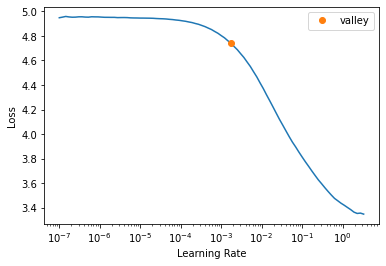

In [13]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 3e-3, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-21-v1.0'))

Better model found at epoch 0 with dice_coeff_deep value: 0.21120908879189879.
Better model found at epoch 1 with dice_coeff_deep value: 0.4861393581270071.
Better model found at epoch 2 with dice_coeff_deep value: 0.4996630888024165.
Better model found at epoch 3 with dice_coeff_deep value: 0.5633065023247906.
Better model found at epoch 4 with dice_coeff_deep value: 0.5857430156813876.
Better model found at epoch 5 with dice_coeff_deep value: 0.6137009341468351.
Better model found at epoch 6 with dice_coeff_deep value: 0.6267574858799404.
Better model found at epoch 7 with dice_coeff_deep value: 0.6342282899597592.
Better model found at epoch 11 with dice_coeff_deep value: 0.6459555440307404.
Better model found at epoch 13 with dice_coeff_deep value: 0.6477312215244024.
Better model found at epoch 15 with dice_coeff_deep value: 0.653716060416414.
Better model found at epoch 17 with dice_coeff_deep value: 0.6571782869354141.


### v1.1

In [7]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.6, val_crop=0.6, aug_p=0.4, sample_empty=True, empty_frac=0.5, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=True),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64)
                          )

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth


In [10]:
learn.load('exp-21-v1.0')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [11]:
learn.unfreeze()

SuggestedLRs(valley=2.75422871709452e-06)

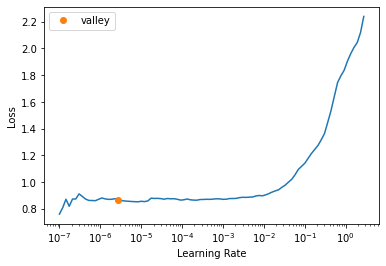

In [12]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, slice(3e-5, 3e-4), cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-21-v1.1'))

Better model found at epoch 0 with dice_coeff_deep value: 0.6554876716069892.
Better model found at epoch 1 with dice_coeff_deep value: 0.6567785776200848.
Better model found at epoch 5 with dice_coeff_deep value: 0.6569096360542852.
Better model found at epoch 6 with dice_coeff_deep value: 0.6583004930037023.
Better model found at epoch 9 with dice_coeff_deep value: 0.6591562950659027.
Better model found at epoch 10 with dice_coeff_deep value: 0.665132557483989.


## exp-20 redacted

That sucked, I ended up stopping it and going to train a pretrained efficientnet b5.

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.6, val_crop=0.6, aug_p=0.4, sample_empty=True, empty_frac=0.1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
timm.list_models('se*')

['selecsls42',
 'selecsls42b',
 'selecsls60',
 'selecsls60b',
 'selecsls84',
 'semnasnet_050',
 'semnasnet_075',
 'semnasnet_100',
 'semnasnet_140',
 'senet154',
 'seresnet18',
 'seresnet34',
 'seresnet50',
 'seresnet50t',
 'seresnet101',
 'seresnet152',
 'seresnet152d',
 'seresnet200d',
 'seresnet269d',
 'seresnext26d_32x4d',
 'seresnext26t_32x4d',
 'seresnext26tn_32x4d',
 'seresnext50_32x4d',
 'seresnext101_32x4d',
 'seresnext101_32x8d']

In [8]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('seresnet101', 5, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64)
                          )

In [9]:
learn.unfreeze()

SuggestedLRs(valley=0.0012022644514217973)

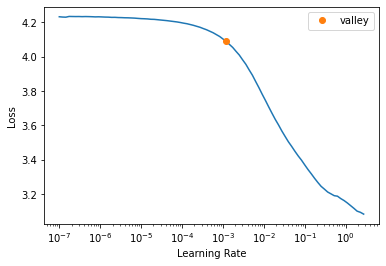

In [10]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(65, 1e-2, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-20-v1.0'))

Better model found at epoch 0 with dice_coeff_deep value: 0.0.
Better model found at epoch 1 with dice_coeff_deep value: 0.20670846929304576.
Better model found at epoch 2 with dice_coeff_deep value: 0.27154036878032267.
Better model found at epoch 3 with dice_coeff_deep value: 0.31612368755421044.
Better model found at epoch 4 with dice_coeff_deep value: 0.4383285810532513.
Better model found at epoch 8 with dice_coeff_deep value: 0.5587945298067579.
Better model found at epoch 12 with dice_coeff_deep value: 0.5834003543312283.
Better model found at epoch 14 with dice_coeff_deep value: 0.6094951984827052.
Better model found at epoch 15 with dice_coeff_deep value: 0.6111799709351885.


## exp-19

The main goal of this experiment is to find if the exp-18-v1 was a fluke.

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.6, val_crop=0.6, aug_p=0.4, sample_empty=True, empty_frac=0.1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b7', 5, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64))

In [8]:
learn.unfreeze()

SuggestedLRs(valley=0.001737800776027143)

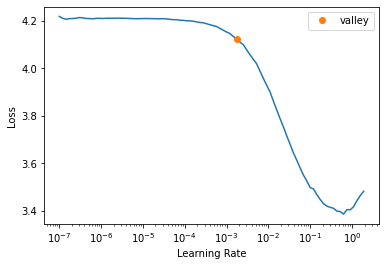

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(30, 1e-2, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-19-v1.0'))

Better model found at epoch 0 with dice_coeff_deep value: 0.0.
Better model found at epoch 1 with dice_coeff_deep value: 0.3090841885087211.
Better model found at epoch 2 with dice_coeff_deep value: 0.48400824192914.
Better model found at epoch 3 with dice_coeff_deep value: 0.49288551061387714.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 10 with dice_coeff_deep value: 0.6585758561290844.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 14 with dice_coeff_deep value: 0.6862212666485549.
Better model found at epoch 17 with dice_coeff_deep value: 0.6932409718092891.
Better model found at epoch 22 with dice_coeff_deep value: 0.7017961628036399.
Better model found at epoch 23 with dice_coeff_deep value: 0.7028898083974051.
Better model found at epoch 27 with dice_coeff_deep value: 0.7105945747263129.


In [11]:
learn.export('uwmadisonutils/exp-19-v1.1.pkl')

In [15]:
learn.load('exp-19-v1.0')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [16]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.6, val_crop=1.0, aug_p=0.4, sample_empty=True, empty_frac=0.1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [17]:
learn.dls = dls

In [18]:
learn.export('uwmadisonutils/exp-19-v1.0.pkl')

## exp-18

### tests

In [26]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.5, aug_p=0.2, sample=True, sample_empty=True, show=False)
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep])
learn.fit_one_cycle(5, 1e-2)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [24]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.5, aug_p=0.4, sample=True, sample_empty=True, show=False)
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep])
learn.fit_one_cycle(5, 1e-2)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [25]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.5, aug_p=0.7, sample=True, sample_empty=True, show=False)
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep])
learn.fit_one_cycle(5, 1e-2)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


### v1

In [19]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.6, val_crop=0.6, aug_p=0.4, sample_empty=True, empty_frac=0.1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [20]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep])

In [8]:
learn.unfreeze()

SuggestedLRs(valley=0.002511886414140463)

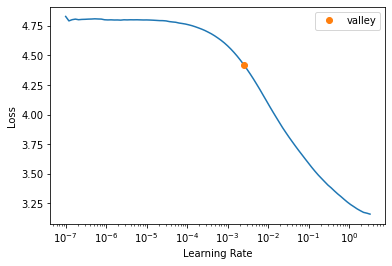

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(60, 1e-2, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-18-v1', at_end=True))

Better model found at epoch 0 with dice_coeff_deep value: 0.0.
Better model found at epoch 1 with dice_coeff_deep value: 0.06726922429899546.
Better model found at epoch 2 with dice_coeff_deep value: 0.4261707433084113.
Better model found at epoch 3 with dice_coeff_deep value: 0.469637770902494.
Better model found at epoch 5 with dice_coeff_deep value: 0.5224410871008883.
Better model found at epoch 6 with dice_coeff_deep value: 0.5684605609336006.
Better model found at epoch 7 with dice_coeff_deep value: 0.6096053453932568.
Better model found at epoch 13 with dice_coeff_deep value: 0.652687609364054.
Better model found at epoch 19 with dice_coeff_deep value: 0.6748458749447765.
Better model found at epoch 22 with dice_coeff_deep value: 0.676437434146236.
Better model found at epoch 23 with dice_coeff_deep value: 0.6771928880209827.
Better model found at epoch 27 with dice_coeff_deep value: 0.6788441252369625.
Better model found at epoch 29 with dice_coeff_deep value: 0.694924179221576

### testing v1 on 0.9 crops and whole dataset

In [21]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.6, val_crop=1.0, aug_p=0.4, sample_empty=False, empty_frac=0.1, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [22]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep])

In [9]:
learn.unfreeze()

In [23]:
learn.load('exp-18-v1')

In [11]:
learn.validate()

(#3) [0.5054166913032532,0.7096628170971885,0.8004405039935358]

The models is surprisingly doing really good on the full dataset even though it trained on crops. I wish to test this one as is it on kaggle to check the progress of each step compared to LB, so I'll save it and make a submission with it, then I'll continue training with more empty samples.

In [12]:
learn.save('exp-18-v1')

Path('models/exp-18-v1.pth')

In [24]:
learn.export('uwmadisonutils/exp-18-v1.pkl')

### v2

There are two ways that I could go with this
1. the first one is to train on the larger crops with full empty slices
2. the other is to use larger sample of empty slices with same 0.6 crops 

The advantages of the second one is that it would increase the amount training the model can do with larger batch size, but this all depends on how the model does in the LB.

So this is a split point, and I would actually need to test both.

Right now, in this version I'll stick with 30 epochs of same crops with higher empty slices sample, then will end with 0.9 crops for 10 epochs and full empty slices.

In [6]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.6, val_crop=0.6, aug_p=0.4, sample_empty=True, empty_frac=0.5, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep])

In [8]:
learn.unfreeze()

In [9]:
learn.load('exp-18-v1')

SuggestedLRs(valley=0.0012022644514217973)

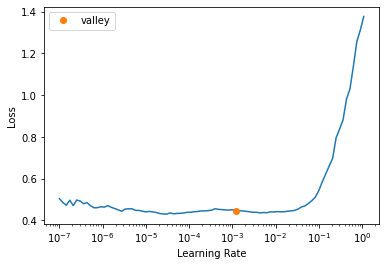

In [10]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(30, 1e-3, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-18-v2.0', at_end=True))

Better model found at epoch 0 with dice_coeff_deep value: 0.7074876869290635.
Better model found at epoch 1 with dice_coeff_deep value: 0.714826644039679.
Better model found at epoch 5 with dice_coeff_deep value: 0.7188723059971242.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 23 with dice_coeff_deep value: 0.7198085605757613.


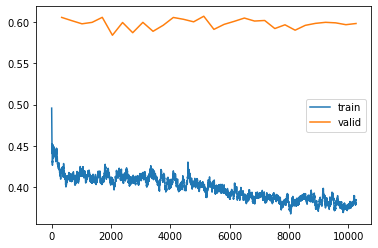

In [ ]:
learn.recorder.plot_loss()

In [12]:
learn.export('uwmadisonutils/exp-18-v2.0.pkl')

In [ ]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, val_crop=0.9, aug_p=0.4, sample_empty=False, show=False)

In [ ]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64))

In [ ]:
learn.load('exp-18-v2.0')

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, 1e-2, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-18-v2.0', at_end=True))

### v3

In this version I'll pick up from v1 with the 0.9 crops and full dataset for 15 epochs or more.

In [10]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, val_crop=0.9, aug_p=0.4, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [16]:
learn = get_custom_learner(dls,
                           UNetPlusPlus('tf_efficientnet_b5', 5, 3, pretrained=False),
                           deep_supervision_loss,
                           unetplusplus_splitter,
                           [dice_coeff_deep, custom_metric_deep],
                           cbs=GradientAccumulation(64))

In [17]:
learn.unfreeze()

In [18]:
learn.load('exp-18-v1')

In [19]:
learn.validate()

(#3) [0.513610303401947,0.7083943804525092,0.7992779615669509]

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0006918309954926372)

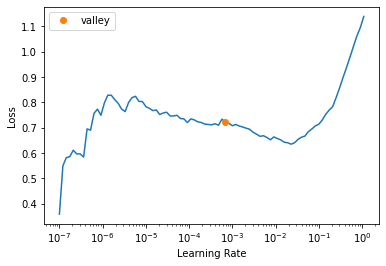

In [14]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(5, 1e-4, cbs=SaveModelCallback(monitor='dice_coeff_deep', fname='exp-18-v3.0'))

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


Better model found at epoch 0 with dice_coeff_deep value: 0.6881723716295644.
Better model found at epoch 1 with dice_coeff_deep value: 0.7054105546309619.
Better model found at epoch 2 with dice_coeff_deep value: 0.7087335280718269.
Better model found at epoch 4 with dice_coeff_deep value: 0.7088573701104145.


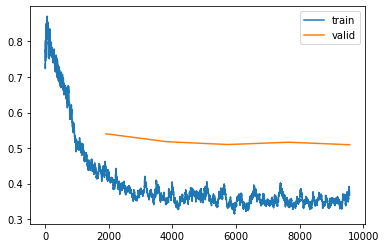

In [21]:
learn.recorder.plot_loss()

In [22]:
learn.export('uwmadisonutils/exp-18-v3.1.pkl')

In [23]:
learn.load('exp-18-v3.0')

/notebooks/fastai/fastai/learner.py:61: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [24]:
learn.export('uwmadisonutils/exp-18-v3.0.pkl')

The results of this experiment are really weird, since it shows that training with little empty slice and small crops actually achieves higher score than training with all empty slices and larger crops.

## exp-17

### v1

In [6]:
def get_train_aug(img_size, crop=0.9, p=0.6):
    crop_size = [round(d*crop) for d in img_size]
    return albumentations.Compose([
            albumentations.RandomCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
            albumentations.OneOf([
                albumentations.GridDistortion(num_steps=5, distort_limit=0.2, p=1.0),
                albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
                ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size[0]//6, max_width=crop_size[1]//6,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.HorizontalFlip(p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            ])

def get_test_aug(img_size, crop=0.9):
    crop_size = [round(d*crop) for d in img_size]
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[1]),
    ])

In [7]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls,
                           build_model('se_resnet50', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-17-v1.0")
                                   ],
                           opt_func=ranger,
                           )

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:781: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


SuggestedLRs(valley=0.001737800776027143)

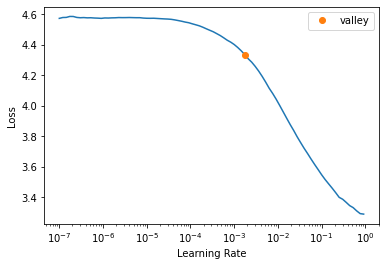

In [9]:
learn.unfreeze()
learn.lr_find()

In [10]:
learn.fit_flat_cos(40, 1e-3)

Better model found at epoch 0 with custom_metric_adj value: 0.285870867591034.
Better model found at epoch 2 with custom_metric_adj value: 0.5145617213497758.
Better model found at epoch 3 with custom_metric_adj value: 0.5749746899970667.
Better model found at epoch 6 with custom_metric_adj value: 0.6467240856592895.
Better model found at epoch 7 with custom_metric_adj value: 0.6704068400387798.
Better model found at epoch 13 with custom_metric_adj value: 0.6806029364211988.
Better model found at epoch 14 with custom_metric_adj value: 0.6947067629273157.
Better model found at epoch 20 with custom_metric_adj value: 0.7177509520328446.
Better model found at epoch 22 with custom_metric_adj value: 0.7313125703622805.
Better model found at epoch 33 with custom_metric_adj value: 0.7498944642484486.
Better model found at epoch 35 with custom_metric_adj value: 0.751249416868415.
Better model found at epoch 36 with custom_metric_adj value: 0.7514134422904455.
Better model found at epoch 37 with

In [11]:
learn.save('exp-17-v1.1')

Path('models/exp-17-v1.1.pth')

### v2

In [8]:
def get_train_aug(img_size, crop=0.9, p=0.6):
    crop_size = [round(d*crop) for d in img_size]
    return albumentations.Compose([
            albumentations.RandomCrop(height=crop_size[0], width=crop_size[0], always_apply=True),
            albumentations.HorizontalFlip(p=p),
            albumentations.OneOf([
                albumentations.GridDistortion(num_steps=5, distort_limit=0.2, p=1.0),
                albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
                ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size[0]//6, max_width=crop_size[1]//6,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.HorizontalFlip(p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            ])

def get_test_aug(img_size, crop=0.9):
    crop_size = [round(d*crop) for d in img_size]
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[0]),
    ])

In [9]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [10]:
learn = get_custom_learner(dls,
                           build_model('se_resnet50', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-17-v2.0")
                                   ],
                           opt_func=ranger,
                           )

In [9]:
learn.load('exp-17-v1.1')
learn.unfreeze()

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:781: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


SuggestedLRs(valley=0.0005754399462603033)

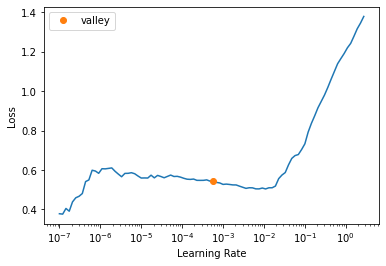

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(25, 1e-3)

Better model found at epoch 1 with custom_metric_adj value: 0.8157235117082914.
Better model found at epoch 17 with custom_metric_adj value: 0.8215503804302182.


In [12]:
learn.export('uwmadisonutils/exp-17-v2.1.pkl')

In [11]:
learn.save('exp-17-v2.1')

Path('models/exp-17-v2.1.pth')

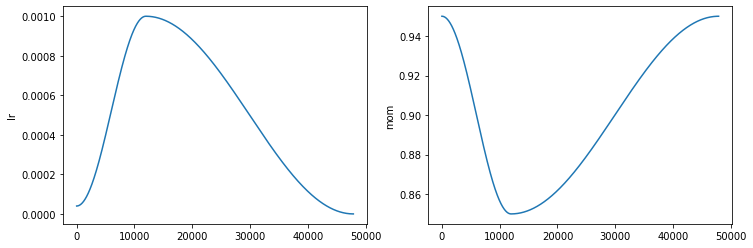

In [ ]:
learn.recorder.plot_sched()

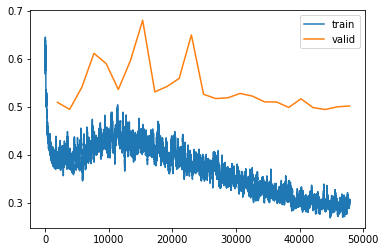

In [16]:
learn.recorder.plot_loss()

In [12]:
learn.load('exp-17-v2.0')

In [13]:
learn.export('uwmadisonutils/exp-17-v2.0.pkl')

### v3

In [6]:
def get_train_aug(img_size, crop=0.9, p=0.6, org=True):
    crop_size = [round(d*crop) for d in img_size]
    if not org:
        crop_size = [crop_size[0], crop_size[0]]
    return albumentations.Compose([
            albumentations.RandomCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
            albumentations.OneOf([
                albumentations.GridDistortion(num_steps=5, distort_limit=0.2, p=1.0),
                albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
                ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size[0]//6, max_width=crop_size[1]//6,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.HorizontalFlip(p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            ])

def get_test_aug(img_size, crop=0.9):
    crop_size = [round(d*crop) for d in img_size]
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[1]),
    ])

In [7]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=1.0, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls,
                           build_model('se_resnet50', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               # SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-17-v2.0")
                                   ],
                           opt_func=ranger,
                           )

In [9]:
learn.load('exp-17-v1.1')

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:781: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


SuggestedLRs(valley=0.00019054606673307717)

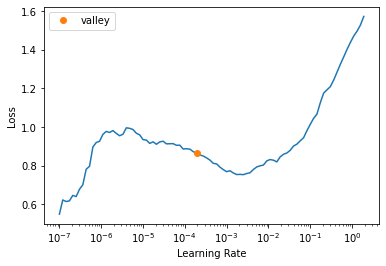

In [28]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 2e-4, 
                    cbs=[SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-17-v3.0")])

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:781: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Better model found at epoch 0 with custom_metric_adj value: 0.7634508442521614.
Better model found at epoch 1 with custom_metric_adj value: 0.7894028489874694.
Better model found at epoch 2 with custom_metric_adj value: 0.8003870627211024.
Better model found at epoch 3 with custom_metric_adj value: 0.8092871233680736.
Better model found at epoch 4 with custom_metric_adj value: 0.8120088783042247.
Better model found at epoch 8 with custom_metric_adj value: 0.8144727994749288.
Better model found at epoch 10 with custom_metric_adj value: 0.8155556940607366.


In [ ]:
learn.save("exp-17-v3.1")

In [ ]:
learn.export("uwmadisonutils/exp-17-v3.1")

In [ ]:
learn.recroder.plot_loss()

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.load('exp-17-v3.0')

In [ ]:
learn.export("uwmadisonutils/exp-17-v3.0")

In [ ]:
!./update-dataset

## exp-16

In [6]:
def get_train_aug(img_size, crop=0.9, p=0.5):
    crop_size = [round(d*crop) for d in img_size]
    return albumentations.Compose([
            albumentations.Resize(height=crop_size[0], width=crop_size[1], always_apply=True),
            albumentations.HorizontalFlip(p=p),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size[0]//10, max_width=crop_size[1]//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.HorizontalFlip(p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            ])


def get_test_aug(img_size, crop=0.9):
    crop_size = [round(d*crop) for d in img_size]
    return  albumentations.Compose([
        albumentations.Resize(height=crop_size[0], width=crop_size[1], always_apply=True),
    ])


In [7]:
dls, dev = get_5C_25D_dls(train, up_size=(320, 384), bs=16, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


### v1.0

In [8]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b7', in_c=5),
                           DiceLossSMP(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-16-v1")
                                   ],
                           # opt_func=ranger,
                           )

SuggestedLRs(valley=0.013182567432522774)

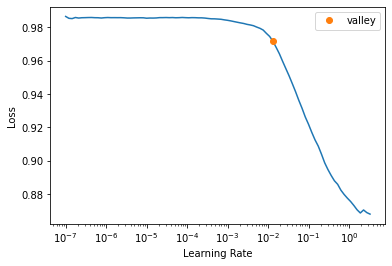

In [9]:
learn.lr_find()

In [10]:
lr = 2e-2

In [11]:
learn.fit_one_cycle(1, lr)

Better model found at epoch 0 with custom_metric_adj value: 0.6727861942456371.


In [9]:
learn.load('exp-16-v1')

SuggestedLRs(valley=0.0004786300996784121)

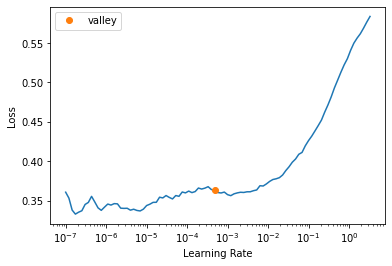

In [12]:
learn.unfreeze()
learn.lr_find()

In [13]:
learn.fit_one_cycle(20, 4e-4)

Better model found at epoch 0 with custom_metric_adj value: 0.6723550293593411.
Better model found at epoch 1 with custom_metric_adj value: 0.7188580240141668.
Better model found at epoch 4 with custom_metric_adj value: 0.7326974786692968.
Better model found at epoch 7 with custom_metric_adj value: 0.7458816854467656.
Better model found at epoch 13 with custom_metric_adj value: 0.7624197664295388.
Better model found at epoch 14 with custom_metric_adj value: 0.7710587410935473.


In [14]:
learn.save('exp-16-v1.1')

Path('models/exp-16-v1.1.pth')

### v1.2

In [8]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b7', in_c=5),
                           DiceLossSMP(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-16-v1.2")
                                   ],
                           # opt_func=ranger,
                           )

SuggestedLRs(valley=0.005248074419796467)

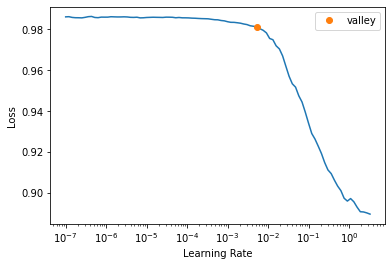

In [9]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 6e-3)

Better model found at epoch 0 with custom_metric_adj value: 0.4563908204929261.
Better model found at epoch 1 with custom_metric_adj value: 0.5658808999815866.
Better model found at epoch 2 with custom_metric_adj value: 0.6400319614360644.
Better model found at epoch 5 with custom_metric_adj value: 0.6791199364777737.
Better model found at epoch 6 with custom_metric_adj value: 0.6853476694680339.
Better model found at epoch 8 with custom_metric_adj value: 0.7000032024838616.
Better model found at epoch 10 with custom_metric_adj value: 0.7106387918399476.


## v2.0

In [7]:
dls, dev = get_5C_25D_dls(train, up_size=(320, 384), bs=16, crop=1.0, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [10]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b7', in_c=5),
                           ComboLoss(ws=[3, 1, 1]), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               # SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-16-v2.0")
                                   ],
                           # opt_func=ranger,
                           )

In [10]:
learn.load('exp-16-v1.3')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0006918309954926372)

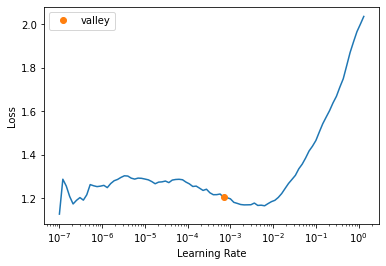

In [11]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, slice(1e-4, 1e-3))

Better model found at epoch 0 with custom_metric_adj value: 0.6498872148854575.
Better model found at epoch 1 with custom_metric_adj value: 0.7001791550211033.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 20 with custom_metric_adj value: 0.7942609355559316.


In [7]:
dls, dev = get_5C_25D_dls(train, up_size=(320, 384), bs=16, crop=1.0, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b7', in_c=5),
                           ComboLoss(ws=[3, 1, 1]), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-16-v3.0")
                                   ],
                           # opt_func=ranger,
                           )

In [9]:
learn.unfreeze()
learn.load('exp-16-v2.0')

SuggestedLRs(valley=0.00015848931798245758)

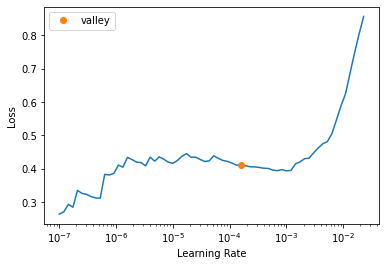

In [13]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(10, slice(1e-4, 1e-3))

Better model found at epoch 0 with custom_metric_adj value: 0.7952891536385777.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 6 with custom_metric_adj value: 0.8053140117590362.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 8 with custom_metric_adj value: 0.8093708058048821.


In [11]:
learn.export('uwmadisonutils/exp-16-v3.1.pkl')

## exp-15

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.4, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-15-v1")
                                   ],
                           opt_func=ranger,
                           )

learn.unfreeze()

SuggestedLRs(valley=0.0030199517495930195)

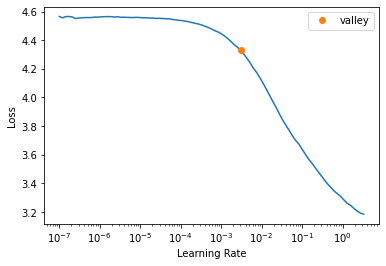

In [8]:
learn.lr_find()

In [9]:
lr = 3e-3

In [10]:
learn.fit_flat_cos(20, lr)

Better model found at epoch 0 with dice_coeff_adj value: 0.1573030720445247.
Better model found at epoch 2 with dice_coeff_adj value: 0.3149942366872489.
Better model found at epoch 3 with dice_coeff_adj value: 0.39325589272834116.
Better model found at epoch 6 with dice_coeff_adj value: 0.4232605237652906.
Better model found at epoch 8 with dice_coeff_adj value: 0.49362917631549197.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 17 with dice_coeff_adj value: 0.563225126626067.
Better model found at epoch 18 with dice_coeff_adj value: 0.5865490216920837.
Better model found at epoch 19 with dice_coeff_adj value: 0.587727571769463.


In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.7, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-15-v2")
                                   ],
                           opt_func=ranger,
                           )

learn.unfreeze()

In [8]:
learn.load('exp-15-v1')

SuggestedLRs(valley=0.0003981071640737355)

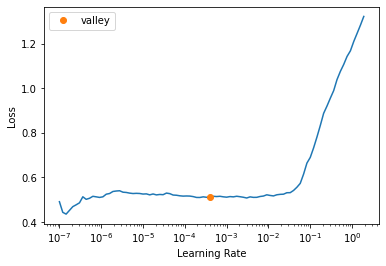

In [9]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(20, 1e-3)

Better model found at epoch 0 with dice_coeff_adj value: 0.6571102855754611.
Better model found at epoch 1 with dice_coeff_adj value: 0.6712326455849723.
Better model found at epoch 2 with dice_coeff_adj value: 0.6748771472792991.
Better model found at epoch 6 with dice_coeff_adj value: 0.6879890449070861.
Better model found at epoch 11 with dice_coeff_adj value: 0.691950496879804.
Better model found at epoch 17 with dice_coeff_adj value: 0.6986530336365232.
Better model found at epoch 18 with dice_coeff_adj value: 0.6998234118399844.


This run probably only need 10 epochs.

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-15-v4")
                                   ],
                           opt_func=ranger,
                           
                           )

learn.unfreeze()

In [12]:
learn.load('exp-15-v2')

SuggestedLRs(valley=0.0006918309954926372)

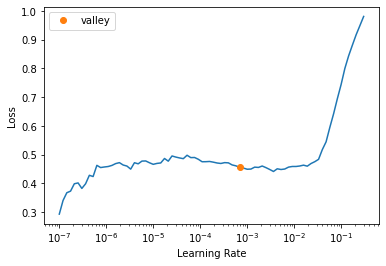

In [13]:
learn.lr_find()

In [14]:
learn.fit_flat_cos(10, 1e-3)

Better model found at epoch 0 with dice_coeff_adj value: 0.6900041560963425.
Better model found at epoch 2 with dice_coeff_adj value: 0.701197111393825.
Better model found at epoch 5 with dice_coeff_adj value: 0.7029430237066803.
Better model found at epoch 6 with dice_coeff_adj value: 0.7061525999289364.
Better model found at epoch 9 with dice_coeff_adj value: 0.7088038539263432.


I need to optimize the time which can make acheive the same results with this model in order to move on to deeper models to avoid training models for very long times.

In [15]:
learn.export('uwmadisonutils/exp-15-v3.pkl')

In [11]:
learn.load('exp-15-v3')

In [12]:
learn.loss_func = DiceLossSMP()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.009120108559727669)

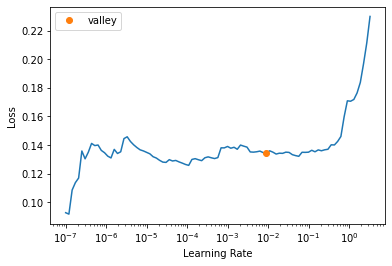

In [15]:
learn.lr_find()

In [13]:
learn.fit_flat_cos(10, 1e-5)

Better model found at epoch 0 with dice_coeff_adj value: 0.7101425143087177.
Better model found at epoch 1 with dice_coeff_adj value: 0.7108997109861682.
Better model found at epoch 2 with dice_coeff_adj value: 0.7134557333012942.


In [ ]:
learn.export('uwmadisonutils/exp-15-v4.0')

In [14]:
learn.load('exp-15-v4')

In [15]:
learn.export('uwmadisonutils/exp-15-v4.1')

## exp-14

Test untrained efficientnet b5 with dice loss

In [10]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [11]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           DiceLossSMP(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-14-v1")
                                   ],
                           opt_func=ranger,
                           )

learn.unfreeze()

SuggestedLRs(valley=0.009120108559727669)

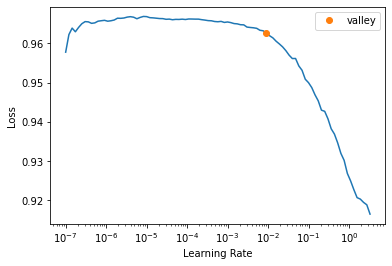

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(40, 0.01)

Better model found at epoch 0 with dice_coeff_adj value: 0.009740469591184148.
Better model found at epoch 1 with dice_coeff_adj value: 0.18056669018042687.
Better model found at epoch 2 with dice_coeff_adj value: 0.2504459648359193.
Better model found at epoch 5 with dice_coeff_adj value: 0.2689493985038031.
Better model found at epoch 7 with dice_coeff_adj value: 0.38345545130792785.
Better model found at epoch 10 with dice_coeff_adj value: 0.5222641824285427.
Better model found at epoch 11 with dice_coeff_adj value: 0.5425763576037125.
Better model found at epoch 17 with dice_coeff_adj value: 0.619302340585848.
Better model found at epoch 22 with dice_coeff_adj value: 0.6230564802818251.
Better model found at epoch 23 with dice_coeff_adj value: 0.6397669301429455.
Better model found at epoch 26 with dice_coeff_adj value: 0.6590180113759054.
Better model found at epoch 28 with dice_coeff_adj value: 0.6639231672833331.
Better model found at epoch 30 with dice_coeff_adj value: 0.664877

In [7]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           DiceLossSMP(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-14-v2")
                                   ],
                           # opt_func=ranger,
                           )

learn.unfreeze()

In [10]:
learn.load('exp-14-v1')

SuggestedLRs(valley=0.0003311311302240938)

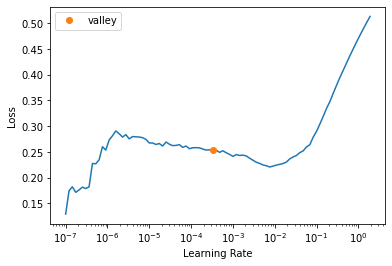

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(15, 1e-3)

Better model found at epoch 0 with dice_coeff_adj value: 0.6847207954835496.
Better model found at epoch 2 with dice_coeff_adj value: 0.7096339890826321.
Better model found at epoch 11 with dice_coeff_adj value: 0.7114586061885834.


In [13]:
learn.export('uwmadisonutils/exp-14-v2.pkl')

In [9]:
learn.load('exp-14-v1')

In [10]:
learn.export('uwmadisonutils/exp-14-v2.1.pkl')

## exp-13 

Train nested unet for longer time on crops then for longer time on completes

In [6]:
dls, dev = get_5C_25D_dls(train, bs=64, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls,
                           NestedUNet(3, 5, deep_supervision=True),
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           cbs=[
                               # GradientAccumulation(64), 
                               # SaveModelCallback(with_opt=True, monitor='custom_metric_deep', fname="exp-13-v1")
                                   ],
                           # opt_func=ranger
                           )

SuggestedLRs(valley=0.0012022644514217973)

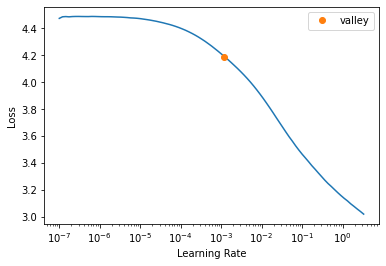

In [8]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(60, 1e-3)

Better model found at epoch 0 with custom_metric_deep value: 0.3145544399537645.
Better model found at epoch 3 with custom_metric_deep value: 0.330738008150037.
Better model found at epoch 5 with custom_metric_deep value: 0.4492906464903504.
Better model found at epoch 6 with custom_metric_deep value: 0.48017240883354995.
Better model found at epoch 7 with custom_metric_deep value: 0.49377888450528284.
Better model found at epoch 8 with custom_metric_deep value: 0.624983711108068.
Better model found at epoch 9 with custom_metric_deep value: 0.630086061503428.
Better model found at epoch 10 with custom_metric_deep value: 0.6741751566968954.
Better model found at epoch 13 with custom_metric_deep value: 0.6943392345157691.
Better model found at epoch 18 with custom_metric_deep value: 0.6946491501731151.
Better model found at epoch 20 with custom_metric_deep value: 0.7129805546824536.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
learn.load('exp-13-v1')

In [12]:
learn.validate()

(#4) [0.9775909185409546,0.6888777528044774,0.8253981410346738,0.7707899857425956]

In [14]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [15]:
learn = get_custom_learner(dls,
                           NestedUNet(3, 5, deep_supervision=True),
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           cbs=[
                               GradientAccumulation(64), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_deep', fname="exp-13-v2")
                                   ],
                           # opt_func=ranger
                           )

In [11]:
learn.load('exp-13-v1')

In [9]:
learn.validate()

(#4) [0.8249685764312744,0.693527544600645,0.8521019108981445,0.788672164379145]

SuggestedLRs(valley=0.00010964782268274575)

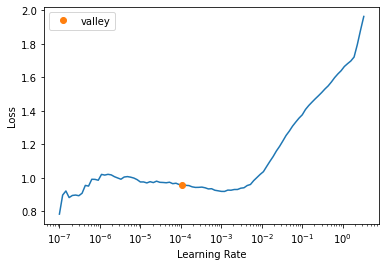

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(15, 1e-4)

Better model found at epoch 0 with custom_metric_deep value: 0.8019419660260819.
Better model found at epoch 2 with custom_metric_deep value: 0.8061809364882732.
Better model found at epoch 3 with custom_metric_deep value: 0.8130494210767285.


In [16]:
learn.load('exp-13-v2')

In [17]:
learn.export('uwmadisonutils/exp-13-v2.pkl')

## exp-12

Should also test with larger batch size and learning rate

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-12-v1")
                                   ],
                           opt_func=ranger,
                           )

learn.unfreeze()

SuggestedLRs(valley=0.002511886414140463)

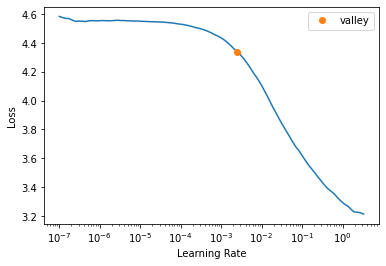

In [8]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(40, 1e-3)

Better model found at epoch 0 with custom_metric_adj value: 0.26531920872151266.
Better model found at epoch 1 with custom_metric_adj value: 0.33193675350952856.
Better model found at epoch 2 with custom_metric_adj value: 0.4193052633947813.
Better model found at epoch 3 with custom_metric_adj value: 0.484236941120801.
Better model found at epoch 4 with custom_metric_adj value: 0.5881458599156066.
Better model found at epoch 6 with custom_metric_adj value: 0.5898038595155106.
Better model found at epoch 7 with custom_metric_adj value: 0.594949423533793.
Better model found at epoch 8 with custom_metric_adj value: 0.6490252205883905.
Better model found at epoch 10 with custom_metric_adj value: 0.6655536484713307.
Better model found at epoch 11 with custom_metric_adj value: 0.6767573204463031.
Better model found at epoch 17 with custom_metric_adj value: 0.7072552170993205.
Better model found at epoch 22 with custom_metric_adj value: 0.7420134554731661.


In [ ]:
learn.save('exp-12-v1.1')

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [12]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               # SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-12-v2")
                                   ],
                           # opt_func=ranger,
                           )

learn.unfreeze()

In [8]:
learn.load('exp-12-v1')

SuggestedLRs(valley=0.0003981071640737355)

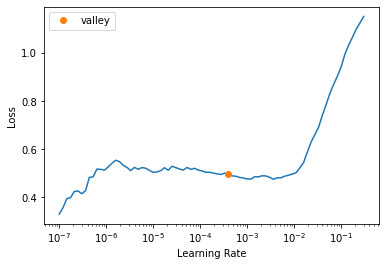

In [10]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 4e-4)

Better model found at epoch 0 with custom_metric_adj value: 0.7972439180271436.
Better model found at epoch 1 with custom_metric_adj value: 0.8018022485870754.
Better model found at epoch 8 with custom_metric_adj value: 0.8142869917771535.
Better model found at epoch 12 with custom_metric_adj value: 0.8161301671463672.
Better model found at epoch 13 with custom_metric_adj value: 0.8170105494366934.


In [13]:
learn.load('exp-12-v2')

In [14]:
learn.validate()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


(#4) [0.5109492540359497,0.7063958725891916,0.8907506370573646,0.8170087312700942]

In [8]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [9]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-12-v3")
                                   ],
                           opt_func=ranger,
                           )

learn.unfreeze()

In [10]:
learn.load('exp-12-v2')

/notebooks/fastai/fastai/learner.py:60: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


In [11]:
learn.loss_func = DiceLossSMP()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.001737800776027143)

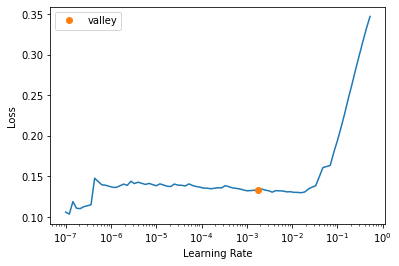

In [12]:
learn.lr_find()

In [13]:
learn.fit_flat_cos(10, 1e-4)

Better model found at epoch 0 with custom_metric_adj value: 0.8201563731484369.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 3 with custom_metric_adj value: 0.8222159666716005.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
learn.export('uwmadisonutils/exp-12-v3.0.pkl')

In [15]:
learn.load('exp-12-v3')

In [16]:
learn.export('uwmadisonutils/exp-12-v3.1.pkl')

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-12-v4")
                                   ],
                           opt_func=ranger,
                           )

learn.unfreeze()

In [8]:
learn.load('exp-12-v3')

In [9]:
learn.loss_func = DiceLossSMP()

In [ ]:
learn.fit_flat_cos(10, 1e-5)

Better model found at epoch 0 with custom_metric_adj value: 0.819075723382696.
Better model found at epoch 1 with custom_metric_adj value: 0.8193618303928708.
Better model found at epoch 3 with custom_metric_adj value: 0.8199754540009794.
Better model found at epoch 5 with custom_metric_adj value: 0.8202948486139233.


In [8]:
learn.load('exp-12-v4')

In [9]:
learn.export('uwmadisonutils/exp-12-v4.pkl')

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b5', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_adj', fname="exp-12-v5")
                                   ],
                           opt_func=ranger,
                           )

learn.unfreeze()

In [8]:
learn.load('exp-12-v4')

In [10]:
learn.loss_func = DiceLossSMP()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0006918309954926372)

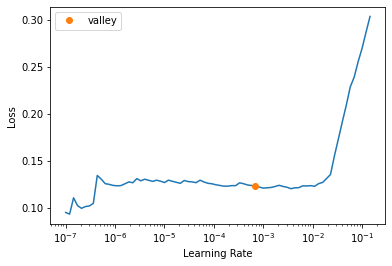

In [11]:
learn.lr_find()

In [12]:
learn.fit_flat_cos(10, 1e-5)

Better model found at epoch 0 with custom_metric_adj value: 0.8196465172670135.
Better model found at epoch 1 with custom_metric_adj value: 0.8202880375910148.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 5 with custom_metric_adj value: 0.8214173469422548.


In [13]:
learn.export('uwmadisonutils/exp-12-v5.1')

In [14]:
learn.load('exp-12-v5')

In [15]:
learn.export('uwmadisonutils/exp-12-v5.0')

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.recorder.plot_sched()

In [10]:
learn.export('uwmadisonutils/exp-12-v2.pkl')

In [11]:
!./update-dataset.sh

Starting upload for file exp-10-v1.0.2.pkl
100%|██████████████████████████████████████| 52.7M/52.7M [00:10<00:00, 5.25MB/s]
Upload successful: exp-10-v1.0.2.pkl (53MB)
Starting upload for file exp-7-v2.pkl
100%|██████████████████████████████████████| 36.2M/36.2M [00:06<00:00, 5.81MB/s]
Upload successful: exp-7-v2.pkl (36MB)
Starting upload for file test-model.pkl
100%|██████████████████████████████████████| 24.2M/24.2M [00:05<00:00, 4.62MB/s]
Upload successful: test-model.pkl (24MB)
Skipping folder: tmpa4766qnz; use '--dir-mode' to upload folders
Starting upload for file __init__.py
0.00B [00:00, ?B/s]
Upload successful: __init__.py (0B)
Skipping folder: tmpc2r_mi8r; use '--dir-mode' to upload folders
Starting upload for file utilities.py
100%|██████████████████████████████████████| 46.2k/46.2k [00:00<00:00, 83.0kB/s]
Upload successful: utilities.py (46KB)
Starting upload for file exp-12-v2.pkl
100%|████████████████████████████████████████| 121M/121M [00:26<00:00, 4.70MB/s]
Upload succ

## exp-11

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b3', in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-11-v1", every_epoch=True)
                                   ],
                           # opt_func=ranger,
                           )

SuggestedLRs(valley=0.0020892962347716093)

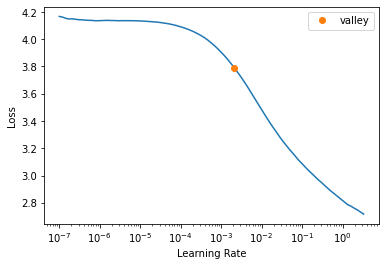

In [8]:
learn.unfreeze()
learn.lr_find()

In [8]:
lr = 2e-3

In [ ]:
learn.fit_one_cycle(50, lr)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [13]:
learn.unfreeze()
learn.load('exp-11-v1_30')
# learn.validate()

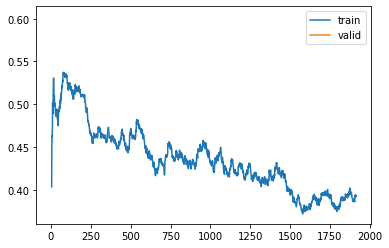

In [14]:
learn.recorder.plot_loss()

In [10]:
lr = 2e-3

In [ ]:
learn.fit_one_cycle(50, lr, start_epoch=30)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


## exp-10

Model: Unet with efficientnet-b5 untrained backbone
1. Train for 20 epochs using 0.5 with sampled empty and frozen encoder
2. Train for 20 epochs using 0.5 with sampled empty and unfrozen encoder
2. Train fro 10 epochs uing 0.9 cropped images

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b3', in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-10-v1")
                                   ],
                           # opt_func=ranger,
                           )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

SuggestedLRs(valley=0.001737800776027143)

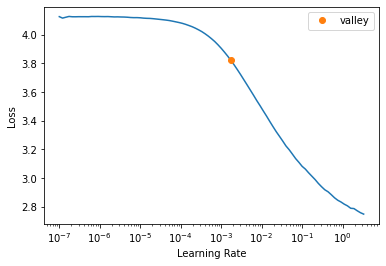

In [8]:
learn.lr_find()

In [9]:
lr = 1e-2

In [10]:
learn.fit_one_cycle(20, lr)

Better model found at epoch 0 with dice_coeff_adj value: 0.3202024466556946.
Better model found at epoch 1 with dice_coeff_adj value: 0.39328695129045144.
Better model found at epoch 2 with dice_coeff_adj value: 0.4706278094429046.
Better model found at epoch 3 with dice_coeff_adj value: 0.5139129952703658.
Better model found at epoch 4 with dice_coeff_adj value: 0.5324493125190206.
Better model found at epoch 5 with dice_coeff_adj value: 0.5486524773778706.
Better model found at epoch 7 with dice_coeff_adj value: 0.5702985130163803.
Better model found at epoch 9 with dice_coeff_adj value: 0.6062752519461698.
Better model found at epoch 10 with dice_coeff_adj value: 0.6142888122349844.
Better model found at epoch 11 with dice_coeff_adj value: 0.622928256925184.
Better model found at epoch 12 with dice_coeff_adj value: 0.6257906517456632.
Better model found at epoch 14 with dice_coeff_adj value: 0.6286192571686445.
Better model found at epoch 15 with dice_coeff_adj value: 0.651765195298

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(lr/100, lr/10))

Better model found at epoch 0 with dice_coeff_adj value: 0.6557721034362194.
Better model found at epoch 2 with dice_coeff_adj value: 0.6597694856863895.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 14 with dice_coeff_adj value: 0.6760510764837925.
Better model found at epoch 15 with dice_coeff_adj value: 0.6792855789982816.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [12]:
learn.save('exp-10-v1.1')

Path('models/exp-10-v1.1.pth')

In [13]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [14]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b3', in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-10-v1.0.1")
                                   ],
                           # opt_func=ranger,
                           )

In [15]:
learn.load('exp-10-v1')

In [ ]:
learn.fine_tune(10, 1e-3)

Better model found at epoch 0 with dice_coeff_adj value: 0.6724963474197723.


Better model found at epoch 0 with dice_coeff_adj value: 0.6821180469708377.
Better model found at epoch 1 with dice_coeff_adj value: 0.6836729587155814.
Better model found at epoch 2 with dice_coeff_adj value: 0.6841604106541009.
Better model found at epoch 4 with dice_coeff_adj value: 0.687418320771221.
Better model found at epoch 5 with dice_coeff_adj value: 0.6889879965778228.
Better model found at epoch 7 with dice_coeff_adj value: 0.692644728911948.


In [ ]:
learn.save('exp-10-v1.0.2')

In [ ]:
learn.export('uwmadisonutils/exp-10-v1.0.2.pkl')

## exp-9

Model: Unet with efficientnet-b3 untrained backbone
1. Train for 40 epochs using 0.5 with sampled empty
2. Train fro 10 epochs uing 0.9 cropped images

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b3', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-9-v1")
                                   ],
                           opt_func=ranger,
                           )

In [8]:
learn.unfreeze()

SuggestedLRs(valley=0.0030199517495930195)

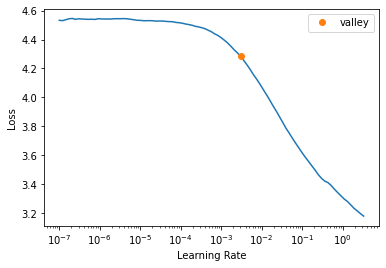

In [9]:
learn.lr_find()

In [10]:
lr = 3e-3

In [11]:
learn.fit_flat_cos(40, lr)

Better model found at epoch 0 with dice_coeff_adj value: 0.1388352159618303.
Better model found at epoch 1 with dice_coeff_adj value: 0.2984505224128475.
Better model found at epoch 3 with dice_coeff_adj value: 0.3958053503421064.
Better model found at epoch 4 with dice_coeff_adj value: 0.4193600972506554.
Better model found at epoch 6 with dice_coeff_adj value: 0.5077048804408907.
Better model found at epoch 7 with dice_coeff_adj value: 0.5230653028434789.
Better model found at epoch 8 with dice_coeff_adj value: 0.5315749693483358.
Better model found at epoch 9 with dice_coeff_adj value: 0.5527383516001269.
Better model found at epoch 12 with dice_coeff_adj value: 0.5551259408014722.
Better model found at epoch 13 with dice_coeff_adj value: 0.5775096966206625.
Better model found at epoch 15 with dice_coeff_adj value: 0.6033105009736023.
Better model found at epoch 19 with dice_coeff_adj value: 0.6284345535330361.
Better model found at epoch 23 with dice_coeff_adj value: 0.633632497910

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b3', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-9-v2")
                                   ],
                           # opt_func=ranger,
                           )

In [8]:
learn.load('exp-9-v1')

In [9]:
learn.unfreeze()

SuggestedLRs(valley=0.0012022644514217973)

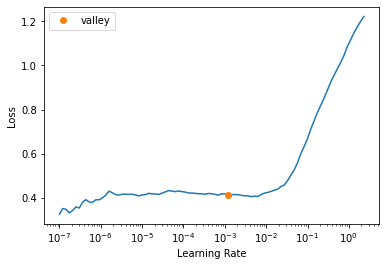

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(10, 1e-3)

Better model found at epoch 0 with dice_coeff_adj value: 0.6776684617679736.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Better model found at epoch 6 with dice_coeff_adj value: 0.691443837537162.
Better model found at epoch 7 with dice_coeff_adj value: 0.703778173279171.


In [9]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [10]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b3', weights=None, in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-9-v2")
                                   ],
                           # opt_func=ranger,
                           )

In [11]:
learn.load('exp-9-v2')

In [12]:
learn.export('uwmadisonutils/exp-9-v2.pkl')

SuggestedLRs(valley=0.0012022644514217973)

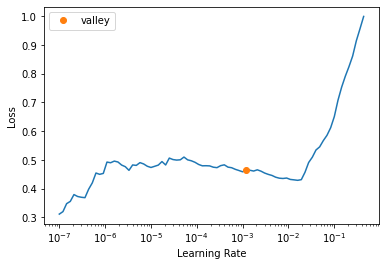

In [9]:
learn.lr_find()

In [10]:
lr = 1e-3

In [11]:
learn.fit_one_cycle(5, lr)

Better model found at epoch 0 with dice_coeff_adj value: 0.6957607002879278.
Better model found at epoch 2 with dice_coeff_adj value: 0.6988603368371253.


In [ ]:
learn.unfreeze()

## exp-8

Model: Unet with efficientnet-b3 backbone
1. Train for 20 epochs using 0.5 with sampled empty
2. Train fro 10 epochs uing 0.9 cropped images

In [15]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [16]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b3', in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-8-v1")
                                   ],
                           )

SuggestedLRs(valley=0.0014454397605732083)

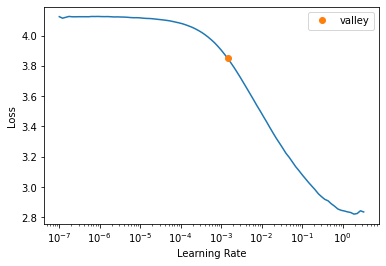

In [8]:
learn.lr_find()

In [9]:
learn.fine_tune(40, 3e-3)

Better model found at epoch 0 with dice_coeff_adj value: 0.3433216521833313.


Better model found at epoch 0 with dice_coeff_adj value: 0.44125331480032703.
Better model found at epoch 1 with dice_coeff_adj value: 0.4650803158730367.
Better model found at epoch 2 with dice_coeff_adj value: 0.4830856584219911.
Better model found at epoch 3 with dice_coeff_adj value: 0.4894324624106419.
Better model found at epoch 4 with dice_coeff_adj value: 0.5085633925220908.
Better model found at epoch 5 with dice_coeff_adj value: 0.5222377790666137.
Better model found at epoch 6 with dice_coeff_adj value: 0.5409438109332367.
Better model found at epoch 7 with dice_coeff_adj value: 0.5517823772825131.
Better model found at epoch 8 with dice_coeff_adj value: 0.5754145883028312.
Better model found at epoch 10 with dice_coeff_adj value: 0.5785233560699425.
Better model found at epoch 12 with dice_coeff_adj value: 0.6025410712563295.
Better model found at epoch 14 with dice_coeff_adj value: 0.6128889220141686.
Better model found at epoch 18 with dice_coeff_adj value: 0.627247796424

In [24]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [25]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b3', in_c=5),
                           ComboLoss(), 
                           unet_splitter,
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-8-v2")
                                   ],
                           )

In [26]:
learn.load('exp-8-v1')

In [22]:
learn.validate()

Better model found at epoch 0 with dice_coeff_adj value: 0.826948230490728.


(#4) [0.5427982807159424,0.6666035884836763,0.826948230490728,0.7628103736879076]

SuggestedLRs(valley=0.0012022644514217973)

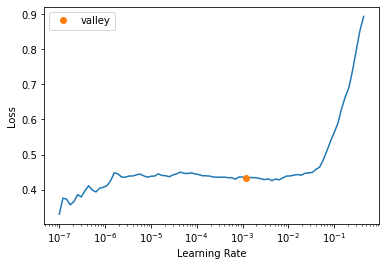

In [27]:
learn.freeze()
learn.lr_find()

In [28]:
lr = 1e-3

In [29]:
learn.fit_one_cycle(5, 1e-3)

Better model found at epoch 0 with dice_coeff_adj value: 0.6582734079818181.
Better model found at epoch 1 with dice_coeff_adj value: 0.6611653281673112.
Better model found at epoch 3 with dice_coeff_adj value: 0.6662857756012946.
Better model found at epoch 4 with dice_coeff_adj value: 0.6699467892188654.


In [30]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(lr/400, lr/4))

Better model found at epoch 0 with dice_coeff_adj value: 0.6649595996213491.
Better model found at epoch 1 with dice_coeff_adj value: 0.6701172822806342.


## exp-7

Model: Nested-Unet
1. Train for 20 epochs using 0.7 with sampled empty
2. Train fro 10 epochs uing 0.9 cropped images

### Implementation

### v1

In [6]:
dls, dev = get_5C_25D_dls(train, bs=32, crop=0.5, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           NestedUNet(3, 5, deep_supervision=True),
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff2, hd_dist2, custom_metric2],
                           cbs=[
                               # GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff2', fname="exp-7-v1")
                                   ],
                           opt_func=ranger
                           )

SuggestedLRs(valley=0.0014454397605732083)

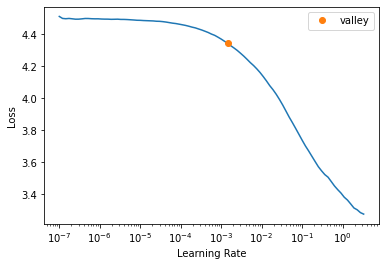

In [8]:
learn.lr_find()

In [9]:
learn.fit_flat_cos(40, 1e-3)

Better model found at epoch 0 with dice_coeff2 value: 0.1263017290885907.
Better model found at epoch 1 with dice_coeff2 value: 0.3269159159810041.
Better model found at epoch 2 with dice_coeff2 value: 0.4147256781322844.
Better model found at epoch 3 with dice_coeff2 value: 0.45608157583098724.
Better model found at epoch 4 with dice_coeff2 value: 0.4964778322141654.
Better model found at epoch 5 with dice_coeff2 value: 0.5001227199501102.
Better model found at epoch 6 with dice_coeff2 value: 0.5611179040754908.
Better model found at epoch 7 with dice_coeff2 value: 0.5643460804835986.
Better model found at epoch 9 with dice_coeff2 value: 0.6033250979043034.
Better model found at epoch 13 with dice_coeff2 value: 0.6055489358909205.
Better model found at epoch 14 with dice_coeff2 value: 0.6185049609387707.
Better model found at epoch 17 with dice_coeff2 value: 0.6287693593579269.
Better model found at epoch 19 with dice_coeff2 value: 0.6552014492626064.
Better model found at epoch 23 wi

In [9]:
# learn.save('exp-7-v1')

### v2

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls,
                           NestedUNet(3, 5, deep_supervision=True),
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_deep', fname="exp-7-v2")
                                   ],
                          )

In [9]:
learn.load('exp-7-v1')

SuggestedLRs(valley=7.585775892948732e-05)

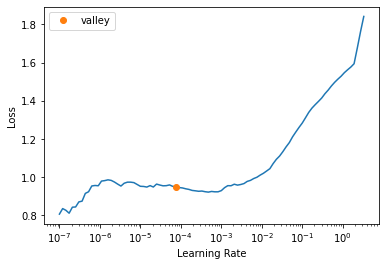

In [10]:
learn.lr_find()

In [10]:
lr = 2e-4

In [11]:
learn.fit_one_cycle(5, lr)

Better model found at epoch 2 with dice_coeff2 value: 0.694966216302431.
Better model found at epoch 3 with dice_coeff2 value: 0.6992605844785746.


### v3

In [12]:
dls, dev = get_5C_25D_dls(train, bs=16, crop=0.9, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [13]:
learn = get_custom_learner(dls,
                           NestedUNet(3, 5, deep_supervision=True),
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_deep', fname="exp-7-v3")
                                   ],
                          )

In [14]:
learn.load('exp-7-v2')

In [15]:
lr = 2e-4

In [16]:
learn.fit_one_cycle(5, lr)

Better model found at epoch 0 with dice_coeff_deep value: 0.6813212907609212.
Better model found at epoch 1 with dice_coeff_deep value: 0.6981766165454032.
Better model found at epoch 3 with dice_coeff_deep value: 0.7040533767999947.


In [17]:
learn.export('exp-8-v3-fe.pkl')

### v2.1

In [8]:
learn = get_custom_learner(dls,
                           NestedUNet(3, 5, deep_supervision=True),
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='dice_coeff_deep', fname="exp-7-v2.1")
                                   ],
                          )

In [11]:
lr = 2e-4

In [ ]:
learn.fit_one_cycle(10, lr)

Better model found at epoch 0 with dice_coeff_deep value: 0.6976102656069608.
Better model found at epoch 5 with dice_coeff_deep value: 0.7018137856572834.
Better model found at epoch 6 with dice_coeff_deep value: 0.7033002534847461.
Better model found at epoch 7 with dice_coeff_deep value: 0.7042709670710319.


In [9]:
learn.load('exp-7-v2.1')

In [10]:
learn.validate()

Better model found at epoch 0 with dice_coeff_deep value: 0.8889926449499596.


(#4) [0.7509059309959412,0.7042709670710319,0.8889926449499596,0.8151039737983883]

In [11]:
learn.export('uwmadisonutils/exp-7-v2.1.pkl')

### v3.1

In [18]:
learn = get_custom_learner(dls,
                           NestedUNet(3, 5, deep_supervision=True),
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff_deep, hd_dist_deep, custom_metric_deep],
                           cbs=[
                               GradientAccumulation(32), 
                               SaveModelCallback(with_opt=True, monitor='custom_metric_deep', fname="exp-7-v3.1")
                                   ],
                          )

In [19]:
learn.load('exp-7-v2.1')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0002290867705596611)

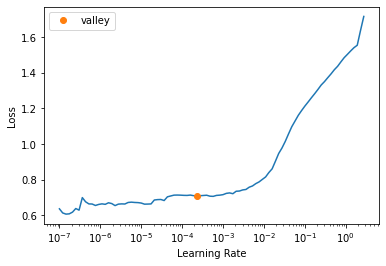

In [20]:
learn.lr_find()

In [21]:
lr = 2e-4

In [22]:
learn.fit_one_cycle(10, lr)

Better model found at epoch 0 with custom_metric_deep value: 0.8081357439969726.
Better model found at epoch 1 with custom_metric_deep value: 0.8082192536845284.
Better model found at epoch 2 with custom_metric_deep value: 0.8120683520821024.
Better model found at epoch 8 with custom_metric_deep value: 0.8122769587660532.


In [23]:
learn.export('exp-8-v3.1-fe.pkl')

## exp-6

### Implementation

In [14]:
@ToTensor
def encodes(self, o:np.ndarray): return TensorImage(image2tensor(o))


class SegmentationAlbumentationsTransform5C(ItemTransform):
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return aug["image"], PILMask.create(aug["mask"])


def get_5C_25D_dls(df, img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group', seed=42):
    
    df = df.copy()
    
    np.random.seed(seed)
    set_seed(seed, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct, seed)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct, seed)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=seed),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=seed)
    else:
        dev = df.sample(frac=1.0, random_state=seed)
        
    if isinstance(img_size, int): img_size = (img_size, img_size)
        
    if img_size[0] >= 310 and img_size[1] >= 360:
        tfms = [[partial(get_25D_image, up_size=img_size)], [partial(get_mask, up_size=img_size), PILMask.create]]
        after_item = [SegmentationAlbumentationsTransform5C(get_train_aug(img_size), 0),
                      SegmentationAlbumentationsTransform5C(get_test_aug(img_size), 1),
                      ToTensor()]
    else:
        tfms = [[get_25D_image, partial(cv2.resize, dsize=img_size)], [get_mask, partial(cv2.resize, dsize=img_size), PILMask.create]]
        after_item = [SegmentationAlbumentationsTransform5C(get_train_aug(img_size), 0), ToTensor()]
    
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=after_item,
                           after_batch=[IntToFloatTensor, Normalize.from_stats([0.485, 0.485, 0.456, 0.406, 0.406],
                                                                               [0.229, 0.229, 0.224, 0.225, 0.225])])
    dls.rng.seed(seed)
    
    if show:
        nrows = bs//4
        ncols = 4
        dls.show_batch(nrows=nrows, ncols=ncols, max_n=bs, figsize=(ncols*3, nrows*3))
        
    return dls, dev


@typedispatch
def show_batch(x:TensorImage, y:TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        x_i = x[i] / x[i].max()
        show_image(x_i[[1, 2, 3]], ctx=ctx, cmap='gray', **kwargs)
        show_image(y[i], ctx=ctx, cmap='Spectral_r', alpha=0.35, **kwargs)
        red_patch = mpatches.Patch(color='red', label='lb')
        green_patch = mpatches.Patch(color='green', label='sb')
        blue_patch = mpatches.Patch(color='blue', label='st')
        ctx.legend(handles=[red_patch, green_patch, blue_patch], fontsize=figsize[0]/2)
        
        
def get_train_aug(img_size, crop=0.9, p=0.4):
    if isinstance(img_size, int): img_size = (img_size, img_size)
    crop_size = [round(crop*size) for size in img_size]
    return albumentations.Compose([
            albumentations.HorizontalFlip(p=p),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=p),
            albumentations.CoarseDropout(
                max_holes=8, min_holes=8,
                max_height=crop_size[0]//10, max_width=crop_size[1]//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
            albumentations.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
            albumentations.RandomCrop(height=crop_size[0], width=crop_size[1], always_apply=True),
            albumentations.HorizontalFlip(p=0.5*p),
            albumentations.OneOf([
                albumentations.MotionBlur(p=0.2*p),
                albumentations.MedianBlur(blur_limit=3, p=0.1*p),
                albumentations.Blur(blur_limit=3, p=0.1*p),
            ], p=0.2*p),
            albumentations.GaussNoise(var_limit=0.001, p=0.2*p),
                albumentations.OneOf([
                    albumentations.OpticalDistortion(p=0.3*p),
                    albumentations.GridDistortion(p=0.1*p),
                    albumentations.PiecewiseAffine(p=0.3*p),
                ], p=0.2*p),
                albumentations.OneOf([
                    albumentations.Sharpen(p=0.2*p),
                    albumentations.Emboss(p=0.2*p),
                    albumentations.RandomBrightnessContrast(p=0.2*p),
                ]),
            ])


def get_test_aug(img_size, crop=0.9):
    crop_size = [round(crop*size) for size in img_size]
    return  albumentations.Compose([
        albumentations.CenterCrop(height=crop_size[0], width=crop_size[0]),
    ])


class TverskyLoss(BaseLoss):
    def __init__(self, *args, mode='multilabel', thresh=0.5, **kwargs):
        super().__init__(smp.losses.TverskyLoss, *args, mode=mode, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

### Round 1

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


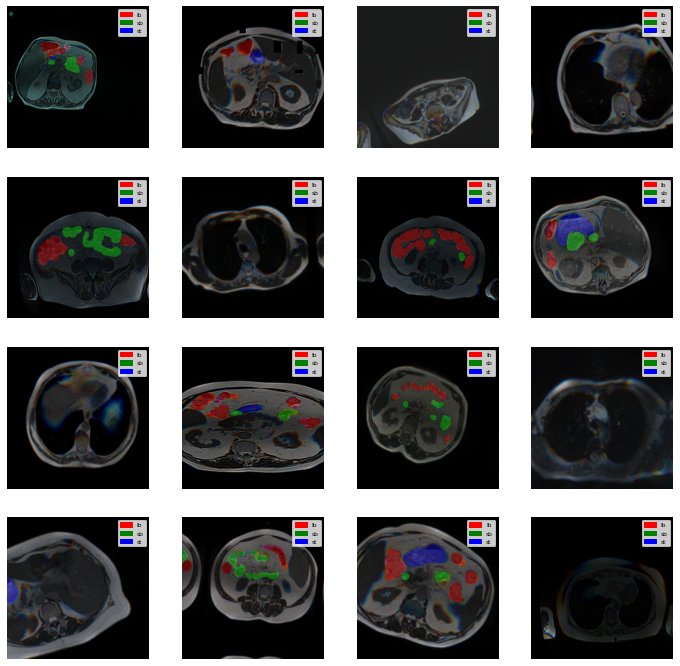

In [15]:
dls, dev = get_5C_25D_dls(train, bs=16, img_size=320, show=True)

In [16]:
unet = smp.FPN(
        encoder_name='efficientnet-b3',      
        encoder_weights="imagenet",    
        in_channels=5,                 
        classes=3,       
        activation=None,
        )

In [17]:
learn = get_custom_learner(dls, 
                           unet, 
                           TverskyLoss(), 
                           unet_splitter,
                           cbs=GradientAccumulation(32), 
                           opt_func=ranger)

In [18]:
learn.fit_one_cycle??

Signature:
learn.fit_one_cycle(
    n_epoch,
    lr_max=None,
    div=25.0,
    div_final=100000.0,
    pct_start=0.25,
    wd=None,
    moms=None,
    cbs=None,
    reset_opt=False,
)
Docstring: Fit `self.model` for `n_epoch` using the 1cycle policy.
File:      /opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py
Type:      method


SuggestedLRs(valley=0.010964781977236271)

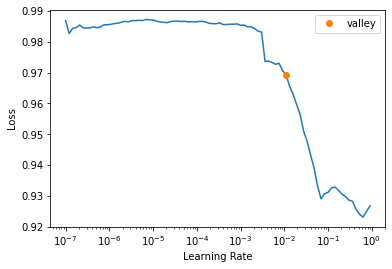

In [10]:
learn.lr_find()

In [11]:
learn.fit_flat_cos(10, 0.001)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [12]:
learn.unfreeze()

In [13]:
learn.fit_flat_cos(10, slice(2e-6, 2e-4))

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [14]:
learn.export('uwmadisonutils/exp-6.pkl')

### Round 2

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, img_size=320, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
unet = smp.FPN(
        encoder_name='efficientnet-b3',      
        encoder_weights="imagenet",    
        in_channels=5,                 
        classes=3,       
        activation=None,
        )

In [13]:
learn = get_custom_learner(dls, 
                           unet, 
                           # TverskyLoss(), 
                           ComboLoss(),
                           unet_splitter,
                           opt_func=ranger,
                           cbs=[GradientAccumulation(32), 
                                SaveModelCallback(with_opt=True, fname="exp-6-round2-v1")])

In [14]:
learn.unfreeze()

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0005754399462603033)

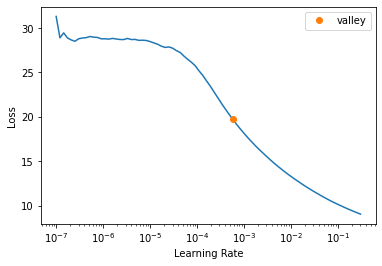

In [15]:
learn.lr_find()

In [17]:
learn.fit_flat_cos(30, 1e-3)

Better model found at epoch 0 with valid_loss value: 0.6789286732673645.
Better model found at epoch 1 with valid_loss value: 0.6071829199790955.
Better model found at epoch 3 with valid_loss value: 0.6001395583152771.
Better model found at epoch 4 with valid_loss value: 0.590327262878418.
Better model found at epoch 5 with valid_loss value: 0.5883287191390991.
Better model found at epoch 7 with valid_loss value: 0.5877362489700317.
Better model found at epoch 8 with valid_loss value: 0.5659072399139404.
Better model found at epoch 9 with valid_loss value: 0.5654075741767883.
Better model found at epoch 11 with valid_loss value: 0.5490801334381104.


KeyboardInterrupt: 

In [ ]:
learn.save('exp-6-v2')

In [ ]:
learn.export('uwmadisonutils/exp-6-v2.pkl')

### Round 3

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


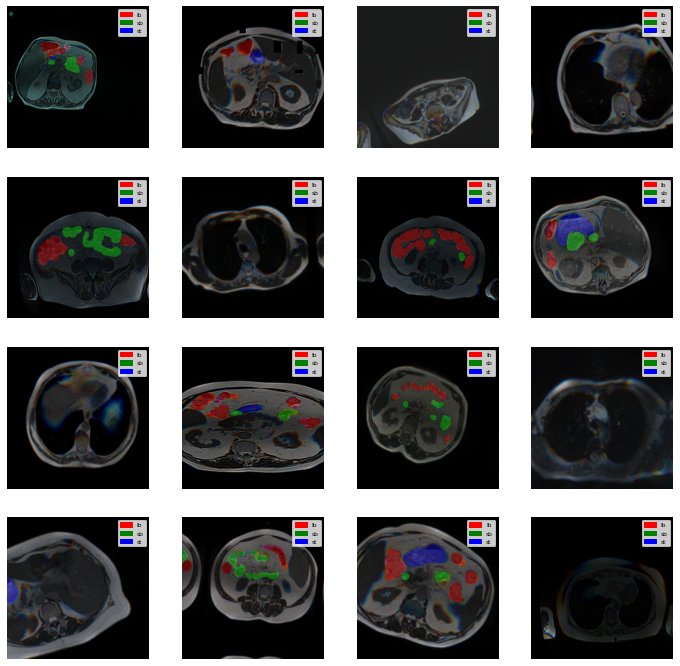

In [6]:
dls, dev = get_5C_25D_dls(train, bs=16, img_size=320, show=True)

In [7]:
unet = smp.FPN(
        encoder_name='efficientnet-b3',      
        encoder_weights="imagenet",    
        in_channels=5,                 
        classes=3,       
        activation=None,
        )

In [10]:
learn = get_custom_learner(dls, 
                           unet, 
                           # TverskyLoss(), 
                           TverskyLoss(),
                           unet_splitter,
                           # opt_func=ranger,
                           cbs=[GradientAccumulation(32), 
                                SaveModelCallback(with_opt=True, monitor='dice_coeff_adj', fname="exp-6-round3-v1")],
                           wd=2e-2)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0030199517495930195)

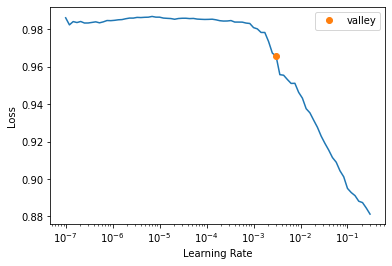

In [11]:
learn.lr_find()

In [ ]:
learn.fine_tune(15, 1e-3)

Better model found at epoch 0 with custom_metric_adj value: 0.6323311095108194.


Better model found at epoch 0 with custom_metric_adj value: 0.6884596672968464.
Better model found at epoch 1 with custom_metric_adj value: 0.7175814737184936.
Better model found at epoch 4 with custom_metric_adj value: 0.7213377462991476.
Better model found at epoch 5 with custom_metric_adj value: 0.7373116687287744.
Better model found at epoch 6 with custom_metric_adj value: 0.7502081208610722.
Better model found at epoch 10 with custom_metric_adj value: 0.755255840599635.


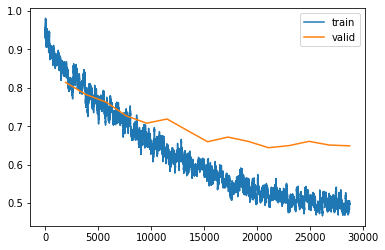

In [12]:
learn.recorder.plot_loss()

In [ ]:
learn.save('exp-6-round3-v2')

In [ ]:
learn.export('uwmadisonutils/exp-6-round3-v2.pkl')

## exp-5

### Implementation

In [12]:
@ToTensor
def encodes(self, o:np.ndarray): return TensorImage(image2tensor(o))


class SegmentationAlbumentationsTransform5C(ItemTransform):
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return aug["image"], PILMask.create(aug["mask"])


def get_5C_25D_dls(df, img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group', seed=42):
    
    df = df.copy()
    
    np.random.seed(seed)
    set_seed(seed, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct, seed)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct, seed)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=seed),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=seed)
    else:
        dev = df.sample(frac=1.0, random_state=seed)
        
    if isinstance(img_size, int): img_size = (img_size, img_size)
        
    if img_size[0] > 310 and img_size[1] > 360:
        tfms = [[partial(get_25D_image, up_size=img_size)], [partial(get_mask, up_size=img_size), PILMask.create]]
        after_item = [SegmentationAlbumentationsTransform5C(get_train_aug(img_size), 0), ToTensor()]
    else:
        tfms = [[get_25D_image, partial(cv2.resize, dsize=img_size)], [get_mask, partial(cv2.resize, dsize=img_size), PILMask.create]]
        after_item = [SegmentationAlbumentationsTransform5C(get_train_aug(img_size), 0), ToTensor()]
    
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=after_item,
                           after_batch=[IntToFloatTensor, Normalize.from_stats([0.485, 0.485, 0.456, 0.406, 0.406],
                                                                               [0.229, 0.229, 0.224, 0.225, 0.225])])
    dls.rng.seed(seed)
    
    if show:
        nrows = bs//4
        ncols = 4
        dls.show_batch(nrows=nrows, ncols=ncols, max_n=bs, figsize=(ncols*3, nrows*3))
        
    return dls, dev


@typedispatch
def show_batch(x:TensorImage, y:TensorMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*3, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(max_n, nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        x_i = x[i] / x[i].max()
        show_image(x_i[[1, 2, 3]], ctx=ctx, cmap='gray', **kwargs)
        show_image(y[i], ctx=ctx, cmap='Spectral_r', alpha=0.35, **kwargs)
        red_patch = mpatches.Patch(color='red', label='lb')
        green_patch = mpatches.Patch(color='green', label='sb')
        blue_patch = mpatches.Patch(color='blue', label='st')
        ctx.legend(handles=[red_patch, green_patch, blue_patch], fontsize=figsize[0]/2)

### Round 1

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


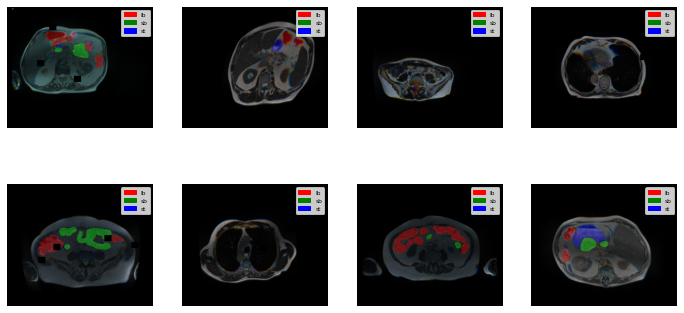

In [13]:
dls, dev = get_5C_25D_dls(train, bs=8, img_size=(320, 384), show=True)

In [16]:
unet = smp.FPN(
        encoder_name='efficientnet-b3',      
        encoder_weights="imagenet",    
        in_channels=5,                 
        classes=3,       
        activation=None,
        )

In [44]:
learn = get_custom_learner(dls, 
                           unet, 
                           ComboLoss(), 
                           unet_splitter,
                           cbs=GradientAccumulation(64))

SuggestedLRs(valley=0.00363078061491251)

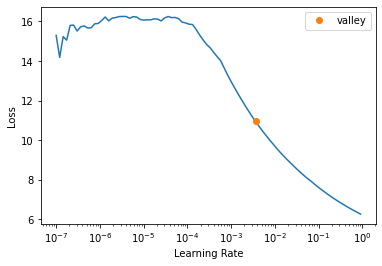

In [45]:
learn.lr_find()

In [46]:
learn.fine_tune(10, 3e-3)

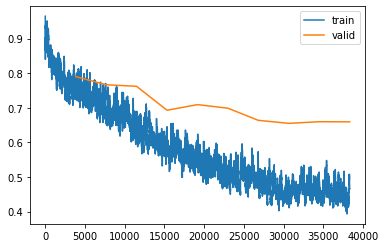

In [47]:
learn.recorder.plot_loss()

In [49]:
learn.export('uwmadisonutils/exp-5.pkl')

## exp-4

### Round 1

In [5]:
IMG_SIZE = (320//2, 384//2)
METHOD = 'crop'
SEED = 42
BS = 32
unet = NestedUNet(3, 3, deep_supervision=True)

In [6]:
def nested_splitter(model):
    layers = nn.Sequential(*model.children())
    return L(layers[:7], layers[7:]).map(params)

In [7]:
dls, dev = get_25D_dls(train, IMG_SIZE, method=METHOD, bs=BS, seed=SEED, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls, 
                           unet, 
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff2, hd_dist2, custom_metric2])

In [9]:
learn.unfreeze()

SuggestedLRs(valley=0.0012022644514217973)

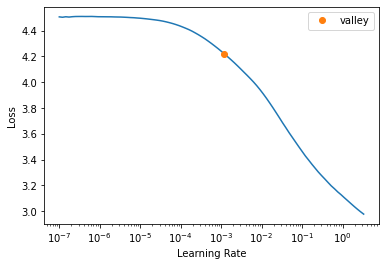

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(40, 1e-2)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



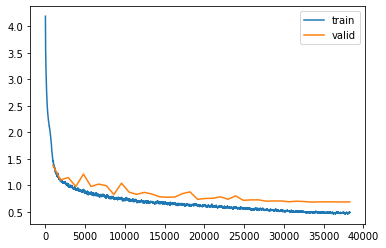

In [12]:
learn.recorder.plot_loss()

In [13]:
learn.save('exp-4-round1')

Path('models/exp-4-round1.pth')

### Round 2

In [5]:
IMG_SIZE = (320, 384)
METHOD = 'crop'
SEED = 42
BS = 8
unet = NestedUNet(3, 3, deep_supervision=True)

In [6]:
def nested_splitter(model):
    layers = nn.Sequential(*model.children())
    return L(layers[:7], layers[7:]).map(params)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


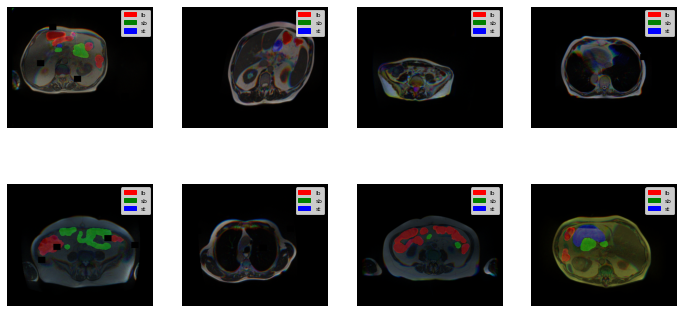

In [7]:
dls, dev = get_25D_dls(train, IMG_SIZE, method=METHOD, bs=BS, seed=SEED, show=True)

In [8]:
learn = get_custom_learner(dls, 
                           unet, 
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff2, hd_dist2, custom_metric2],
                           cbs=GradientAccumulation(64))

In [9]:
learn.load('exp-4-round1')

SuggestedLRs(valley=0.00363078061491251)

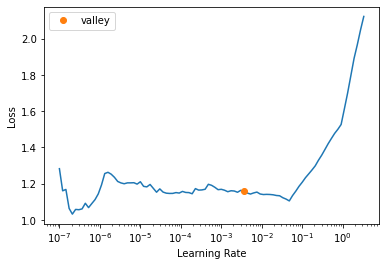

In [10]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(1, 3e-3)

In [13]:
learn.unfreeze()

In [14]:
learn.fit_one_cycle(3, slice(7e-6, 3e-3))

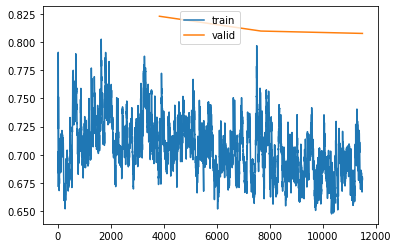

In [15]:
learn.recorder.plot_loss()

In [16]:
learn.save('exp-4-round2-v1')

Path('models/exp-4-round2-v1.pth')

In [17]:
learn.export('uwmadisonutils/exp-4-round2-v1.pkl')

## exp-3

Train nested unet with deep supervision using progressive resizing for 50 epochs using 5 different sizes.

### Round 1

In [5]:
IMG_SIZE = 64
METHOD = 'crop'
SEED = 42
BS = 64
unet = NestedUNet(3, 3, deep_supervision=True)

In [6]:
dls, dev = get_25D_dls(train, IMG_SIZE, method=METHOD, bs=BS, seed=SEED, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [8]:
learn = get_custom_learner(dls, 
                           unet, 
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff2, hd_dist2, custom_metric2],
                           opt_func=ranger)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.002511886414140463)

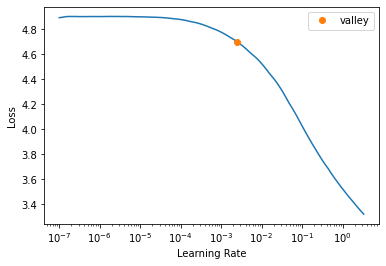

In [9]:
learn.lr_find()

In [10]:
learn.fit_one_cycle(10, lr_max=2e-3)

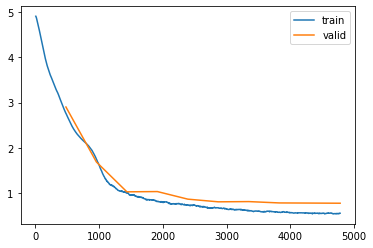

In [12]:
learn.recorder.plot_loss()

In [11]:
learn.save('exp-3-round1')

Path('models/exp-3-round1.pth')

### Round 2

In [5]:
IMG_SIZE = 128
METHOD = 'crop'
SEED = 42
BS = 32
unet = NestedUNet(3, 3, deep_supervision=True)

In [6]:
dls, dev = get_25D_dls(train, IMG_SIZE, method=METHOD, bs=BS, seed=SEED, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls, 
                           unet, 
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff2, hd_dist2, custom_metric2],
                           opt_func=ranger)

In [11]:
learn.load('exp-3-round1')

SuggestedLRs(valley=0.0003981071640737355)

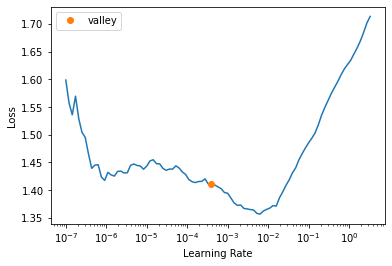

In [10]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(10, lr_max=3e-4)

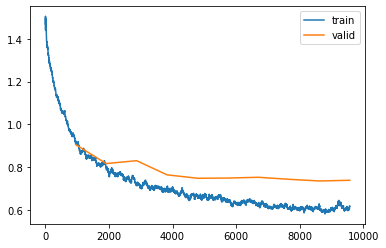

In [13]:
learn.recorder.plot_loss()

In [14]:
learn.save('exp-3-round2')

Path('models/exp-3-round2.pth')

### Round 3

In [5]:
IMG_SIZE = 256
METHOD = 'crop'
SEED = 42
BS = 16
unet = NestedUNet(3, 3, deep_supervision=True)

In [6]:
dls, dev = get_25D_dls(train, IMG_SIZE, method=METHOD, bs=BS, seed=SEED, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [7]:
learn = get_custom_learner(dls, 
                           unet, 
                           deep_supervision_loss, 
                           nested_splitter,
                           metrics=[dice_coeff2, hd_dist2, custom_metric2],
                           opt_func=ranger)

In [10]:
learn.load('exp-3-round2')

SuggestedLRs(valley=0.0002754228771664202)

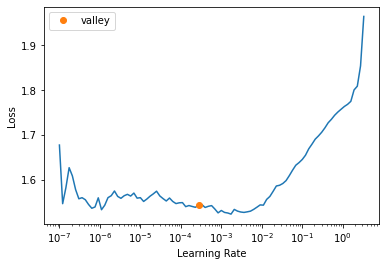

In [9]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(5, 2e-4)

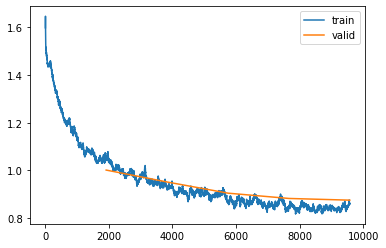

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('exp-3-round3')

Path('models/exp-3-round3.pth')

## exp-2

In [5]:
IMG_SIZE = (320, 384)
SEED = 42
BS = 8
unet = build_model('efficientnet-b3')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


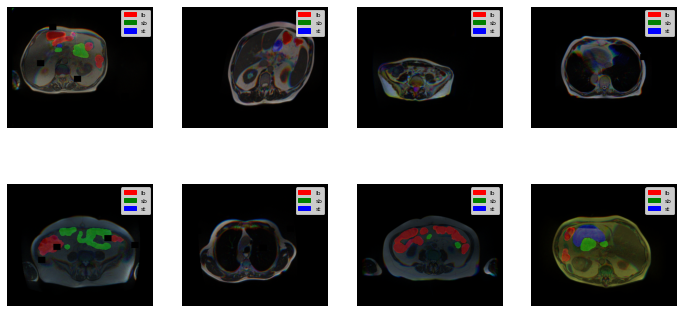

In [6]:
dls, dev = get_25D_dls(train, IMG_SIZE, bs=BS, seed=SEED)

### v1

In [7]:
learn = get_custom_learner(dls, unet, ComboLoss(), unet_splitter, seed=SEED)

SuggestedLRs(valley=0.002511886414140463)

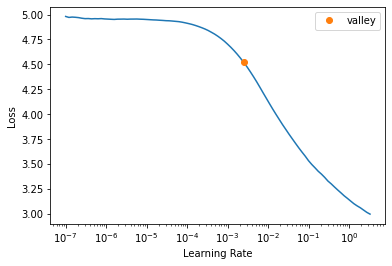

In [8]:
learn.lr_find()

In [9]:
lr = 2e-3

In [10]:
learn.fine_tune(6, lr)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
learn.save('exp-2-v1')

Path('models/exp-2-v1.pth')

In [12]:
learn.export('uwmadisonutils/exp-2-v1.pkl')

### v2

In [11]:
learn.load('exp-2-v1')

In [9]:
learn.unfreeze()

SuggestedLRs(valley=2.0892961401841603e-05)

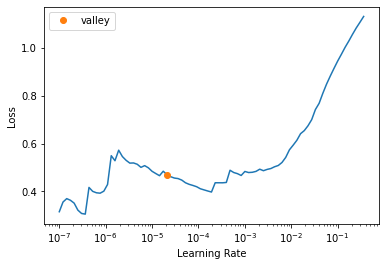

In [10]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(5, slice(3e-6, 3e-5))

In [13]:
learn.export('uwmadisonutils/exp-2-v2.pkl')

In [14]:
!sh update-dataset.sh

Starting upload for file exp-1-v1.pkl
100%|██████████████████████████████████████| 30.1M/30.1M [00:07<00:00, 4.48MB/s]
Upload successful: exp-1-v1.pkl (30MB)
Skipping folder: tmpa4766qnz; use '--dir-mode' to upload folders
Starting upload for file exp-2-v1.pkl
100%|██████████████████████████████████████| 52.9M/52.9M [00:12<00:00, 4.47MB/s]
Upload successful: exp-2-v1.pkl (53MB)
Starting upload for file __init__.py
0.00B [00:00, ?B/s]
Upload successful: __init__.py (0B)
Skipping folder: tmpc2r_mi8r; use '--dir-mode' to upload folders
Starting upload for file utilities.py
100%|██████████████████████████████████████| 46.0k/46.0k [00:00<00:00, 80.8kB/s]
Upload successful: utilities.py (46KB)
Skipping folder: models; use '--dir-mode' to upload folders
Skipping folder: __pycache__; use '--dir-mode' to upload folders
Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file exp-2-v2.pkl
100%|██████████████████████████████████████| 52.7M/52.7M [00:09<00:0

## exp-1

### Configuration

In [5]:
IMG_SIZE = (320, 384)
SEED = 42
BS = 8
unet = build_model('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


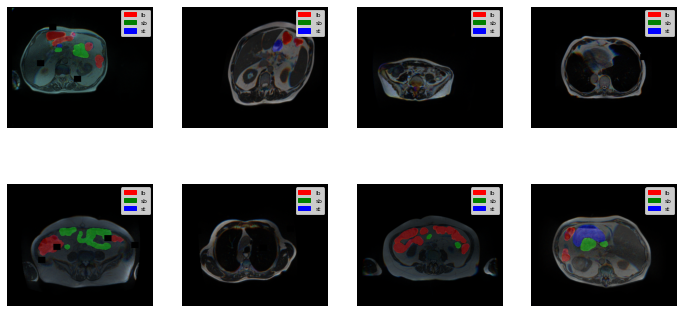

In [6]:
dls, dev = get_25D_dls(train, IMG_SIZE, bs=BS, seed=SEED)

### v1

In [7]:
learn = get_custom_learner(dls, unet, ComboLoss(), unet_splitter, seed=SEED)

SuggestedLRs(valley=0.0020892962347716093)

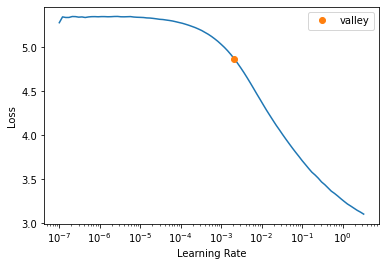

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(20, slice(3e-3))

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
learn.save('exp-1-v1')

Path('models/exp-1-v1.pth')

In [11]:
learn.export('uwmadisonutils/models/exp-1-v1.pkl')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


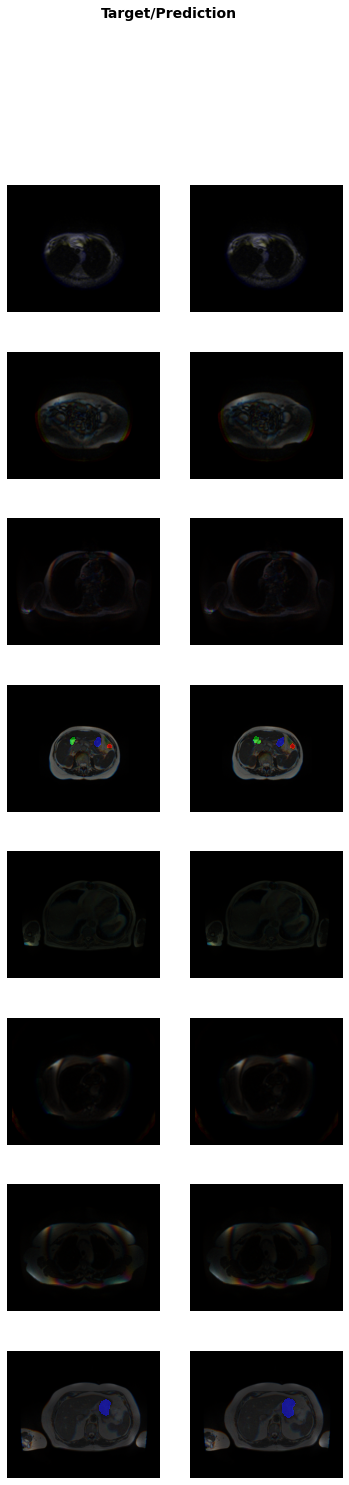

In [12]:
learn.show_results()

### v2

In [10]:
learn.load('exp-1-v1')

In [11]:
learn.unfreeze()

SuggestedLRs(valley=2.0892961401841603e-05)

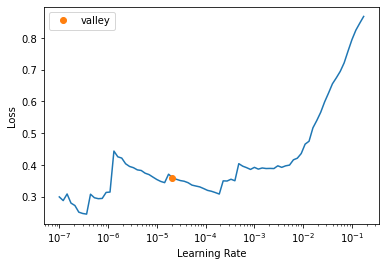

In [9]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 2e-5)

In [ ]:
learn.save('exp-1-v2')

In [ ]:
learn.export('uwmadisonutils/models/exp-1-v2.pkl')

In [ ]:
learn.show_results()

## Testing validation strategy

The idea is to train several models on sample and full data then test them on kaggle to find if the validation strategy works.

The models will be:
1. resnet18 
2. resnet18 with self attention
3. resnet34 
4. resnet34 with self attention

### resnet18

In [ ]:
sample_dls, sample_dev = get_aug_dls(train, aug_transforms(), img_size=224, method='squish', bs=8, sample=True, show=False, val='custom', val_pct=0.2, frac=0.3)
dls, dev = get_aug_dls(train, aug_transforms(), img_size=224, method='squish', bs=16, sample=False, show=False, val='custom', val_pct=0.2)

#### Sample

In [20]:
resnet18_sample = get_learner(sample_dls, resnet18, DiceBCELoss())
resnet18_sample.fit_one_cycle(1, 1e-3)

#### Full

In [21]:
resnet18_full = get_learner(dls, resnet18, DiceBCELoss())
resnet18_full.fit_one_cycle(1, 1e-3)
resnet18_full.export('models/resnet18_full.pkl')

### resnet18 with self attention

#### Sample

In [22]:
resnet18_sa_sample = get_learner(sample_dls, resnet18, DiceBCELoss(), self_attention=True)
resnet18_sa_sample.fit_one_cycle(1, 1e-3)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


#### Full

In [19]:
resnet18_sa_full = get_learner(dls, resnet18, DiceBCELoss(), self_attention=True)
resnet18_sa_full.fit_one_cycle(1, 1e-3)
resnet18_sa_full.export('models/resnet18_sa_full.pkl')

### resnet34 

#### Sample

In [20]:
resnet34_sample = get_learner(sample_dls, resnet34, DiceBCELoss())
resnet34_sample.fit_one_cycle(1, 3e-3)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


#### Full

In [21]:
resnet34_full = get_learner(dls, resnet34, DiceBCELoss())
resnet34_full.fit_one_cycle(1, 3e-3)
resnet34_full.export('models/resnet34_full.pkl')

### resnet34 with self attention

#### Sample

In [20]:
resnet34_sa_sample = get_learner(sample_dls, resnet34, DiceBCELoss(), self_attention=True, opt_func=ranger)
resnet34_sa_sample.fit_flat_cos(1, 1e-3)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


#### Full

In [19]:
resnet34_sa_full = get_learner(dls, resnet34, DiceBCELoss(), self_attention=True, opt_func=ranger)
resnet34_sa_full.fit_flat_cos(1, 1e-3)
resnet34_sa_full.export('models/resnet34_sa_full.pkl')

## Efficientnet B0 v1

### Sample

In [18]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=True, show=False, val='custom')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [19]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

SuggestedLRs(valley=0.005248074419796467)

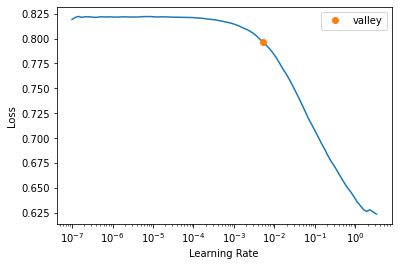

In [20]:
learn.lr_find()

In [21]:
learn.fit_flat_cos(10, 2e-2)

In [22]:
learn.unfreeze()
learn.fit_flat_cos(15, 4e-4)

### Full

In [18]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=False, show=False, val='custom')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [19]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

SuggestedLRs(valley=0.002511886414140463)

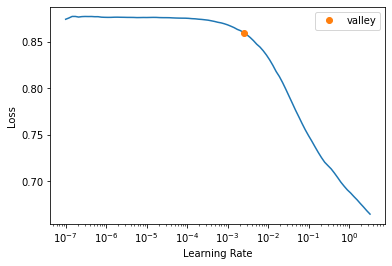

In [20]:
learn.lr_find()

In [21]:
learn.fit_flat_cos(10, 2e-2)

In [22]:
learn.unfreeze()
learn.fit_flat_cos(15, 4e-4)

In [23]:
learn.export('models/efficientnet-b0-v1.pkl')

## Efficientnet B0 v2 (Extra augmentations)

### 1.3

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


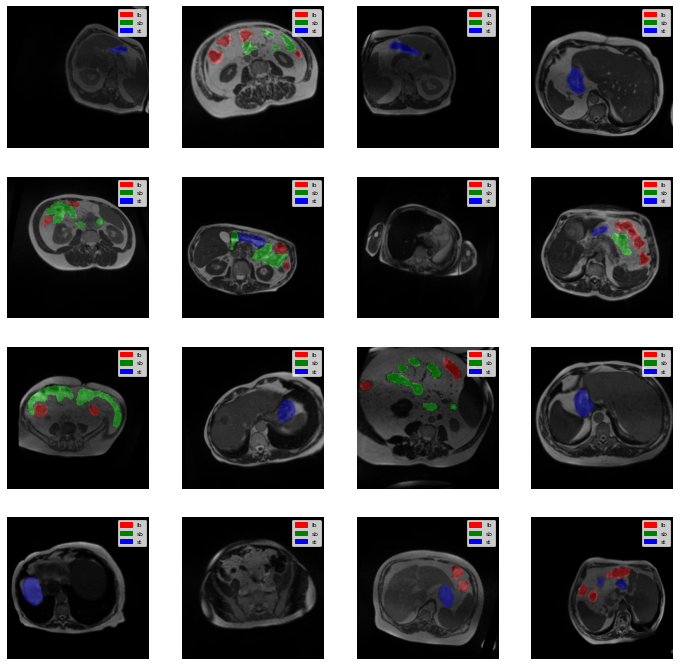

In [18]:
dls, dev = get_aug_dls(train, aug_transforms(mult=1.3), bs=16, sample=True, sample_empty=True, show=True, val='group')

In [19]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

In [ ]:
learn.fit_flat_cos(20, 2e-2)

Achieve a slightly better Dice score. Let's try decreasing it a little notch again.

### 1.5

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


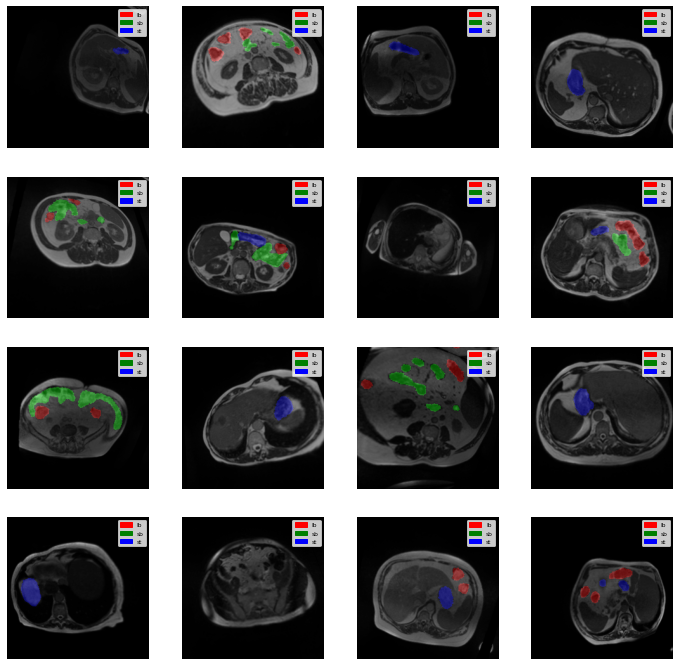

In [21]:
dls, dev = get_aug_dls(train, aug_transforms(mult=1.5), bs=16, sample=True, sample_empty=True, show=True, val='group')

In [22]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

In [32]:
learn.fit_flat_cos(10, 2e-2)

Doesn't do as goood as 

### 1.7

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


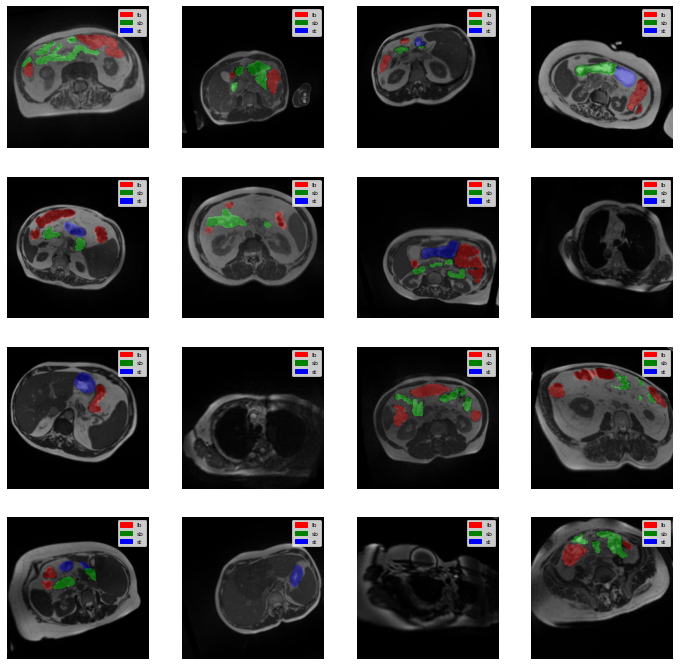

In [24]:
dls, dev = get_aug_dls(train, aug_transforms(mult=1.8), bs=16, sample=True, sample_empty=True, show=True, val='group')

SuggestedLRs(valley=0.004365158267319202)

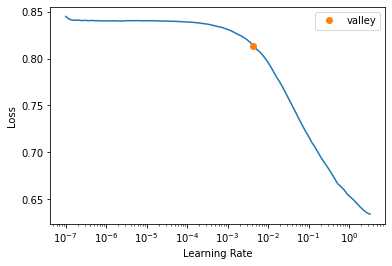

In [25]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)
learn.lr_find()

In [26]:
learn.fit_flat_cos(10, 2e-2)

### 1.3 for 20 epochs

In [18]:
dls, dev = get_aug_dls(train, aug_transforms(mult=1.3), bs=16, sample=True, sample_empty=True, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [19]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

In [20]:
learn.fit_flat_cos(20, 2e-2)

KeyboardInterrupt: 

### Compare with 20 epochs with default agumentations

In [18]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=True, sample_empty=True, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [19]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

In [20]:
learn.fit_flat_cos(20, 2e-2)

### Default agumentations for 20 epochs

In [20]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=True, sample_empty=True, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [21]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

SuggestedLRs(valley=0.00363078061491251)

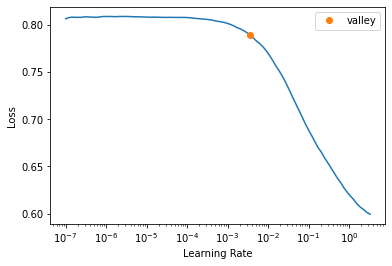

In [22]:
learn.lr_find()

In [23]:
learn.fit_flat_cos(20, 2e-2)

### Full

In [18]:
dls, dev = get_aug_dls(train, aug_transforms(mult=1.3), bs=16, sample=False, sample_empty=False, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [19]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [ ]:
learn.fit_flat_cos(20, 2e-2)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
learn.unfreeze()
learn.fit_flat_cos(10, 4e-4)

In [ ]:
learn.export('models/efficientnet-b0-v2pkl')

## Efficientnet b0 v3

In [18]:
dls, dev = get_aug_dls(train, aug_transforms(), bs=16, sample=False, show=False, val='group')

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [19]:
unet = build_model('efficientnet-b0')
learn = get_custom_learner(dls, unet, DiceBCELoss(), unet_splitter, opt_func=ranger)

SuggestedLRs(valley=0.0063095735386013985)

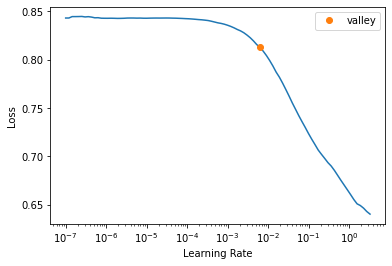

In [20]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(20, 2e-2)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_flat_cos(20, 4e-4)

In [ ]:
learn.export('models/efficientnet-b0-v3.pkl')

## Efficientnet B0 V4 (Albumentations)

### Implementation

In [18]:
import albumentations

In [19]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug, split_idx): store_attr()
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [20]:
def get_train_aug(img_size):
    if isinstance(img_size, int): img_size = (img_size, img_size)
    return albumentations.Compose([
            albumentations.HorizontalFlip(p=0.5),
            albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            albumentations.OneOf([
            albumentations.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albumentations.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            albumentations.CoarseDropout(max_holes=8, max_height=img_size[0]//20, max_width=img_size[1]//20,
                             min_holes=5, fill_value=0, mask_fill_value=0, p=0.5)
    ])

In [21]:
def get_dls(df, img_size=224, method='squish', bs=16, sample=False, sample_empty=False, frac=0.2, val_pct=0.2, show=True, val='group'):
    
    df = df.copy()
    
    np.random.seed(SEED)
    set_seed(SEED, True)
    
    if val == 'group':
        df = add_group_valid(df, val_pct)
    elif val == 'custom':
        df = add_custom_valid(df, val_pct)
    
        
    if sample_empty:
        df = pd.concat([
            df.query('n_segs == 0 & is_valid == False').sample(frac=0.1, replace=False, random_state=SEED),
            df.query('n_segs != 0 | is_valid == True')
        ])
    
    if sample:
        dev = df.sample(frac=frac, random_state=SEED)
    else:
        dev = df
    
    tfms = [[get_image, PILImageBW.create], [get_mask, PILMask.create]]
    splits = ColSplitter()(dev)
    dsets = Datasets(dev, tfms, splits=splits)
    dls = dsets.dataloaders(bs=bs, after_item=[Resize(img_size, method=method),
                                               SegmentationAlbumentationsTransform(get_train_aug(img_size), 0),
                                               ToTensor()],
                           after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])
    dls.rng.seed(SEED)
    
    if show:
        dls.show_batch(nrows=bs//4, ncols=4, max_n=bs, figsize=(12, 12))
        
    return dls, dev

### Control

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


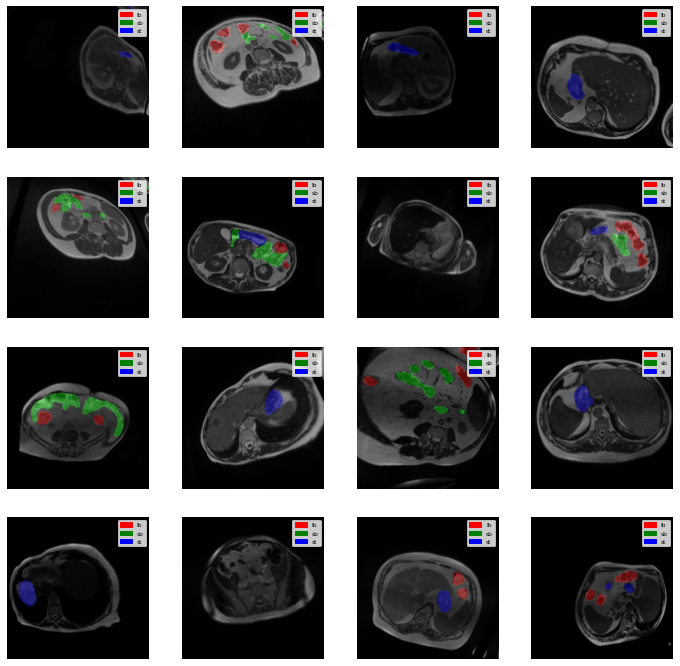

In [22]:
dls, dev = get_aug_dls(train, aug_transforms(mult=2.0), sample=True, sample_empty=True, show=True)

In [23]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.005248074419796467)

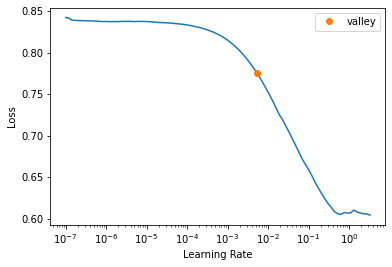

In [36]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(10, 1e-2)

### Test

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


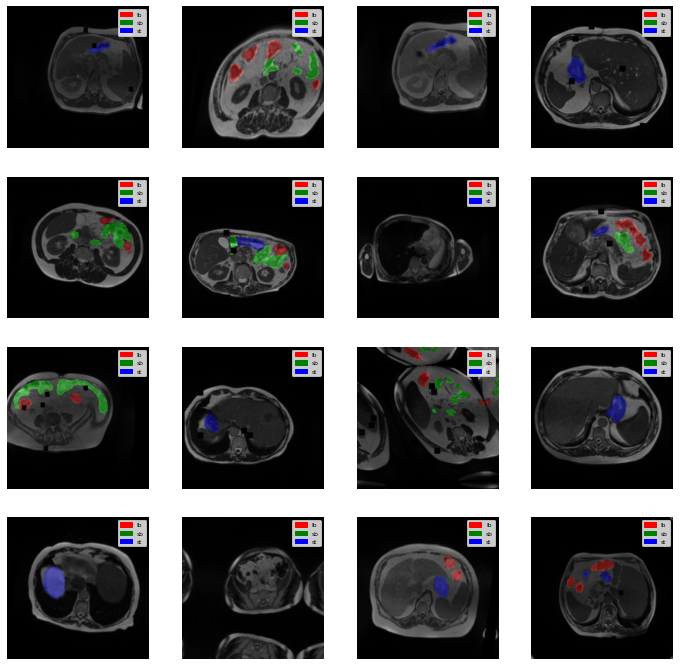

In [25]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=True)

In [26]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [27]:
learn.fit_one_cycle(10, 1e-2)

### Full Model Prototype

In [28]:
dls, dev = get_dls(train, sample=False, sample_empty=False, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [29]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [30]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.export('models/efficientnet-b0-v4.pkl')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, (2e-5, 2e-3)) 

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [ ]:
learn.export('models/efficientnet-b0-v4.1.pkl')

## Efficientnet B0 v5 (weight loss weights)

### Implementation

In [19]:
class DiceBCEModule(Module):
    def __init__(self, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5]):
        store_attr()
        
    def forward(self, inp:Tensor, targ:Tensor) -> Tensor:
        inp = inp.view(-1)
        targ = targ.view(-1)
        
        if self.from_logits: 
            bce_loss = nn.BCEWithLogitsLoss()(inp, targ)
            inp = torch.sigmoid(inp)
            
            
        intersection = (inp * targ).sum()                            
        dice = (2.*intersection + self.eps)/(inp.sum() + targ.sum() + self.eps)  
        
        return self.ws[0]*(1 - dice) + self.ws[1]*bce_loss
    
class DiceBCELoss(BaseLoss):
    def __init__(self, *args, eps:float=1e-5, from_logits=True, ws=[0.5, 0.5], thresh=0.5, **kwargs):
        super().__init__(DiceBCEModule, *args, eps=eps, from_logits=from_logits, ws=ws, flatten=False, is_2d=True, floatify=True, **kwargs)
        self.thresh = thresh
    
    def decodes(self, x:Tensor) -> Tensor:
        "Converts model output to target format"
        return (x>self.thresh).long()

    def activation(self, x:Tensor) -> Tensor:
        "`nn.BCEWithLogitsLoss`'s fused activation function applied to model output"
        return torch.sigmoid(x)

### Test

In [24]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [25]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(ws=(0.8, 0.2)), unet_splitter)

In [26]:
learn.fit_one_cycle(10, 1e-2)

In [27]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [28]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(ws=(0.7, 0.3)), unet_splitter)

In [29]:
learn.fit_one_cycle(10, 2e-2)

Let's use ranger instead of adam and test this again.

In [34]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [35]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(ws=(0.7, 0.3)), unet_splitter, opt_func=ranger)

In [33]:
learn.fit_one_cycle(10, 2e-2)

We have a winner.

I want to test one last thing, what if use fit_flat_cos?

In [36]:
learn.fit_flat_cos(10, 2e-2)

One cycle scheduling is more stable, but flat cosine annealing reached better results in the end. I think that I'll need to test both of them on the full dataset and public LB.

### Full with one cycle scheduling

In [19]:
dls, dev = get_dls(train, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [20]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b0'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [21]:
lr = 2e-2

In [ ]:
learn.fit_one_cycle(15, lr)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(lr/100, lr))

In [ ]:
learn.export('models/efficientnet-b0-v5.0.pkl')

### Full with flat cosine annealing

In [19]:
dls, dev = get_dls(train, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [20]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b0'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [22]:
lr = 2e-2

In [23]:
learn.fit_flat_cos(15, lr)

In [24]:
learn.unfreeze()
learn.fit_flat_cos(15, slice(lr/100, lr))

In [25]:
learn.export('models/efficientnet-b0-v5.1.pkl')

## Efficientnet B1 V5

In [20]:
dls, dev = get_dls(train, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [21]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b1'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

In [22]:
lr = 2e-2

In [23]:
learn.fit_one_cycle(15, lr)

In [24]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(lr/100, lr))

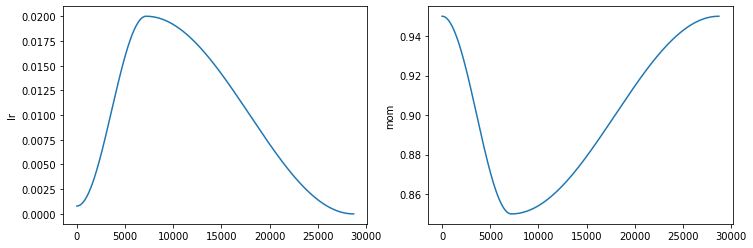

In [28]:
learn.recorder.plot_sched()

In [25]:
learn.export('models/efficientnet-b1-v5.0.pkl')

## Efficientnet B1 V6 

### Control

In [79]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [80]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b1'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger)

In [81]:
learn.fit_one_cycle(3, 2e-2)

### Test

In [22]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [23]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b1'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger)

In [24]:
learn.fine_tune(2, 2e-2)

It seems that training the decoder first for some time is actually a good idea. Now let's test weight decay.

In [29]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [30]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b1'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger,
                           wd=1e-3)

In [ ]:
learn.fit_one_cycle(3, 2e-2)

### Full model

In [20]:
dls, dev = get_dls(train, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [31]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b1'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger,
                           wd=1e-3)

In [32]:
learn.validate()

TypeError: Exception occured in `Recorder` when calling event `after_batch`:
	unsupported operand type(s) for *: 'NoneType' and 'int'

SuggestedLRs(valley=0.0063095735386013985)

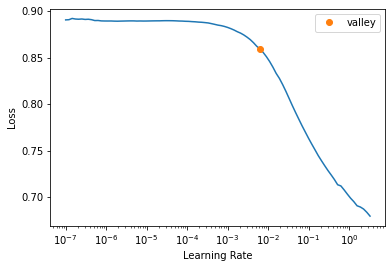

In [31]:
learn.lr_find()

In [44]:
lr = 2e-2

In [62]:
learn.validate()

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.06589121079950563 0.0022491208239464075
0.11198481456567988 0.011944020983441179
0.07917665830394108 0.016944189009529244
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.11822061874223598 0.003557086695925785
0.1963793538226331 0.015671528634128448
0.22864031424963324 0.042049535594730875
0.11634836110209056 0.02322893182898214
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0591423935975295 0.0021370448524576785
0.14691284895962833 0.01541104199934756
0.1124129151362098 0.023272368811539046
0.0 0.0
0.0 0.0
0.00570677936092859 0.0
0.08518417989644854 0.000456535938559468
0.1958975400455271 0.008432441411939873
0.3811448845299179 0.03171653088976462
0.2903644940211726 0.030965539154274982
0.10280961781483641 0.010039641524938758
0.0 0.0
0.0 0.0
0.0 0.0


KeyboardInterrupt: 

In [45]:
learn.fit_one_cycle(20, lr)

TypeError: Exception occured in `Recorder` when calling event `after_batch`:
	unsupported operand type(s) for *: 'NoneType' and 'int'

In [ ]:
learn.export('models/efficientnet-b1-v6.1.pkl')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-6, 1e-4))

In [ ]:
learn.export('models/efficientnet-b1-v6.2.pkl')

## Efficientnet B1 V7 (Naive post processing)

### Implementation

The idea is to make a naive threshold for which to zero out predicted masks in order to reduce false positives as they reduce the metrics.

In [146]:
t = pd.read_csv(data_path+'train.csv', low_memory=False)

def get_pixels(rle):
    if isinstance(rle, str):
        return sum([int(x) for i, x in enumerate(rle.split(' ')) if (i+1) % 2 == 0]) 
    else:
        return 999
    
t['pixels'] = t.segmentation.apply(get_pixels)
t.groupby('class').pixels.min()

class
large_bowel    11
small_bowel    29
stomach        12
Name: pixels, dtype: int64

Now let's make new version of metrics that adjusts the predictions based on this.

In [217]:
def post_process(inp):
    inp[np.where(inp.sum((2, 3)) < 11)] = 0 
    return inp

def dice_coeff_adj(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    eps = 1e-5
    dice_scores = []
    for i in range(targ.shape[0]):
        dice_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            I = (targ[i, j] * inp[i, j]).sum()
            U =  targ[i, j].sum() + inp[i, j].sum()
            dice_i.append((2.*I)/(U+eps))
        if dice_i:
            dice_scores.append(np.mean(dice_i))
    
    if dice_scores:
        return np.mean(dice_scores)
    else:
        return 0
    
    
def hd_dist_per_slice(inp, targ):    
    inp = np.argwhere(inp) / np.array(inp.shape)
    targ = np.argwhere(targ) / np.array(targ.shape)
    # if len(targ) == 0:
    #     inp = 1 - inp
    #     targ = 1 - targ
    haussdorf_dist = 1 - directed_hausdorff(inp, targ, SEED)[0]
    return haussdorf_dist if haussdorf_dist > 0 else 0

def hd_dist_adj(inp, targ):
    inp = np.where(inp.cpu().detach().numpy() > 0.5, 1, 0)
    targ = targ.cpu().detach().numpy()
    inp = post_process(inp)
    hd_scores = []
    for i in range(targ.shape[0]):
        hd_i = []
        for j in range(targ.shape[1]):
            if inp[i, j].sum() == targ[i, j].sum() == 0:
                continue
            hd_i.append(hd_dist_per_slice(inp[i, j], targ[i, j]))
        if hd_i:
            hd_scores.append(np.mean(hd_i))
    if hd_scores:
        return np.mean(hd_scores)
    else:
        return 0

def custom_metric_adj(inp, targ):
    hd_score_per_batch = hd_dist_adj(inp, targ)
    dice_score_per_batch = dice_coeff_adj(inp, targ)
    
    return 0.4*dice_score_per_batch + 0.6*hd_score_per_batch

In [218]:
def get_custom_learner(dls, model, loss_func, splitter, seed=SEED, **kwargs):
    set_seed(seed, True)
    learn = Learner(dls, model, metrics=[dice_coeff, dice_coeff_adj, hd_dist, hd_dist_adj, custom_metric, custom_metric_adj], loss_func=DiceBCELoss(), splitter=splitter, **kwargs).to_fp16()
    learn.freeze()
    return learn

### Test

In [224]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [225]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [226]:
learn.fit_one_cycle(5, 2e-2)

### Make threshold per class

In [228]:
def post_process(inp):
    inp[np.where(inp.sum((2, 3)) < [11, 29, 12])] = 0 
    return inp

In [229]:
dls, dev = get_dls(train, sample=True, sample_empty=True, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [230]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), DiceBCELoss(), unet_splitter)

In [231]:
learn.fit_one_cycle(5, 2e-2)

### Full Model

I'll train my best model so far and I'll increase epochs to improve performance more, and I'll see how post processing improves the score on LB insha'Allah.

In [23]:
dls, dev = get_dls(train, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [24]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b1'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger)

In [21]:
lr = 2e-2

In [25]:
learn.fit_one_cycle(15, lr)

In [26]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(lr/100, lr))

In [27]:
learn.export('models/efficientnet-b1-v7.pkl')

## Efficientnet B2 V8

In [22]:
dls, dev = get_dls(train, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [21]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b2'), 
                           DiceBCELoss(ws=(0.7, 0.3)),
                           unet_splitter,
                           opt_func=ranger)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

In [22]:
lr = 2e-2

In [23]:
learn.fit_one_cycle(35, lr)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
learn.export('models/efficientnet-b2-v8.pkl')

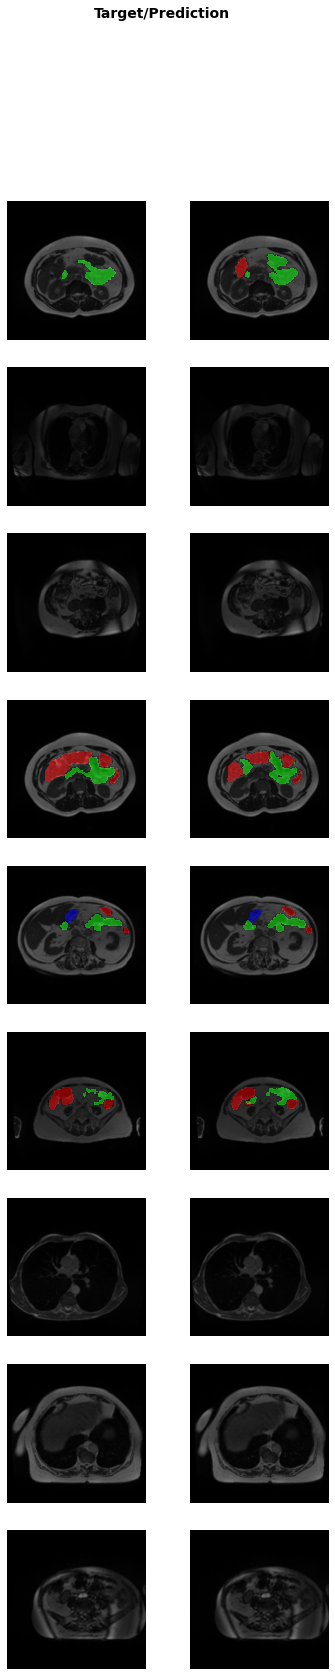

In [27]:
learn.show_results()

## Efficientnet B2 v9

In [23]:
dls, dev = get_25D_dls(train, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [24]:
learn = get_custom_learner(dls,
                           build_model('efficientnet-b2'), 
                           DiceFocalLoss(),
                           unet_splitter,
                           opt_func=ranger)

SuggestedLRs(valley=0.00363078061491251)

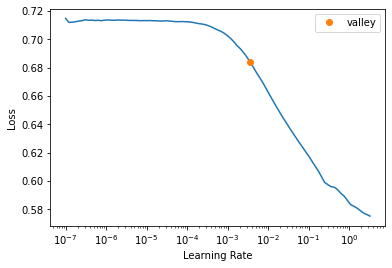

In [25]:
learn.lr_find()

In [26]:
lr = 2e-2

In [ ]:
learn.fit_one_cycle(35, lr)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
learn.export('models/efficientnet-b2-v9.0.pkl')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(lr/400, lr/40))

In [ ]:
learn.export('models/efficientnet-b2-v9.1.pkl')

## Unet# efficientnet b0

In [25]:
dls, dev = get_25D_dls(train, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [26]:
def splitter(model):
    return L(model.encoder, model.decoder, model.final).map(params)

In [36]:
unet = UNetDash(timm.create_model('efficientnet_b0', features_only=True))

In [37]:
learn = get_custom_learner(dls, unet, ComboLoss(), splitter)

SuggestedLRs(valley=0.009120108559727669)

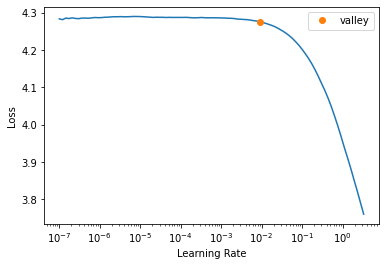

In [38]:
learn.lr_find()

In [39]:
learn.fit_flat_cos(15, 3e-2)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [40]:
learn.export('models/efficientnet-b0-unet-dash.pkl')

## Efficientnet b0 v12

In [23]:
img_size = [320, 384]
hf_img_size = [x//2 for x in img_size]

In [24]:
dls, dev = get_25D_dls(train, hf_img_size, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [25]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

SuggestedLRs(valley=0.0030199517495930195)

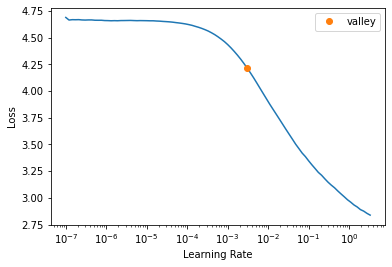

In [26]:
learn.lr_find()

In [28]:
lr = 3e-3

In [29]:
learn.fit_one_cycle(10, slice(lr))

In [31]:
learn.save('efficientnet-b0-v12-stage1')

Path('models/efficientnet-b0-v12-stage1.pth')

The models seems to overfit after this stage, so it would be better to keep training decoder longer instead of training the encoder in this stage.

In [32]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(lr/400, lr/4))

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [33]:
learn.save('efficientnet-b0-v12-stage2')

Path('models/efficientnet-b0-v12-stage2.pth')

In [38]:
dls, dev = get_25D_dls(train, img_size, show=False)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [39]:
learn = get_custom_learner(dls, build_model('efficientnet-b0'), ComboLoss(), unet_splitter)

In [42]:
learn.load('efficientnet-b0-v12-stage2')

In [43]:
learn.freeze()

SuggestedLRs(valley=0.009120108559727669)

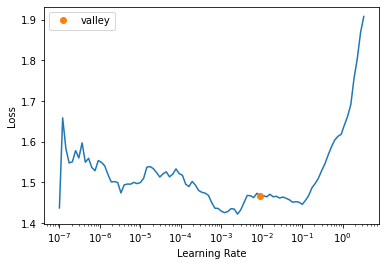

In [44]:
learn.lr_find()

In [45]:
lr = 4e-4

In [ ]:
learn.fit_one_cycle(10, lr)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr/400, lr/4))

In [ ]:
learn.export('kaggle-models/efficientnet-b0-v12.pkl')

## Nested Unet (Deep Supervision)

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1131: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


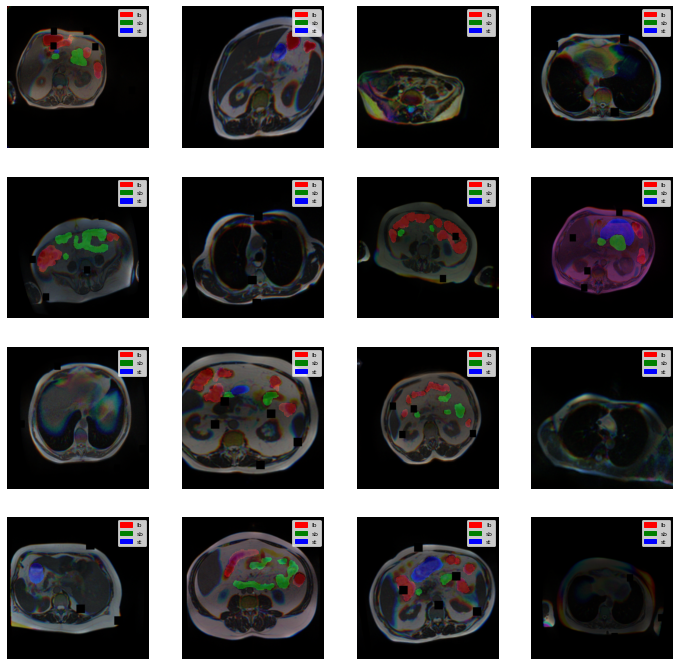

In [25]:
dls, dev = get_25D_dls(train, img_size=320)

In [33]:
learn = get_custom_learner(dls, NestedUNet(3, 3, deep_supervision=True), deep_supervision_loss, splitter, metrics=[dice_coeff2, hd_dist2, custom_metric2])

SuggestedLRs(valley=0.0012022644514217973)

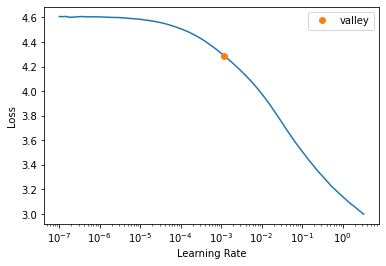

In [34]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(15, 1e-2)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

